---

## **Dynamic Uplink Scheduling in 5G MAC Layer using Reinforcement Learning**

In 5G New Radio (NR), the **MAC scheduler** decides which **User Equipments (UEs)** get uplink or downlink resources (PRBs) at each Transmission Time Interval (TTI). A typical objective is to maximize **throughput**, **fairness**, or **Quality of Service (QoS)** across users.

Traditional scheduling algorithms (e.g., Proportional Fair, Round Robin) use fixed heuristics. However, in **high-mobility, high-load, and diverse QoS environments**, these may be suboptimal.

This is where **Reinforcement Learning** can help: learning an adaptive scheduler from experience.

### 2. **Environment Design (MDP Formulation)**

| Component         | Description                                                                                                    |                                                           |
| ----------------- | -------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------- |
| **State $s_t$**   | Buffer status reports (BSR), Channel Quality Indicators (CQI), HARQ feedback, UE priority/QoS, past throughput |                                                           |
| **Action $a_t$**  | Resource allocation decision: e.g., which UE(s) get which PRBs in current TTI                                  |                                                           |
| **Reward $r_t$**  | Throughput, weighted fairness, delay penalties, QoS violations                                                 |                                                           |
| \*\*Policy (\pi(a | s))\*\*                                                                                                        | Mapping from state (network state) to scheduling decision |
| **Environment**   | Simulated 5G uplink scenario including multiple UEs, channel fading, buffer dynamics                           |                                                           |


### 3. **Simple Example Setup**

#### Uplink RL Scheduler:

* **10 UEs** with different buffer sizes and CQI.
* **RL Agent** selects a UE every TTI (1 ms) to allocate full bandwidth.
* **Reward** is:

  $$
  r_t = \text{transmitted bits}_t - \lambda \cdot \text{delay}_t
  $$

  where delay penalizes old packets.


### 4. **Algorithm Choice**

* **Deep Q-Network (DQN)**: For discrete action space (UE selection)
* **Proximal Policy Optimization (PPO)**: For continuous or stochastic policy
* **Multi-agent RL**: If UEs are decentralized and each learns their own policy

### 5. **Implementation Tools**

* **Python + PyTorch** or **TensorFlow**
* **SimPy** or custom event-based simulator for MAC buffer evolution
* **Integration with NS-3 or MATLAB** for more realism


### 6. **Possible Extensions**

| Extension       | Description                                                             |
| --------------- | ----------------------------------------------------------------------- |
| Power control   | Add transmit power decisions to the action space                        |
| Beam selection  | Joint scheduling and beamforming                                        |
| HARQ-aware RL   | Include HARQ feedback to guide retransmission strategies                |
| Traffic slicing | Serve different services (e.g., URLLC vs eMBB) with adaptive priorities |


### 7. **Outcome**

With enough training, the RL scheduler **learns**:

* When to prioritize low-latency traffic
* When to serve high-throughput users
* How to balance fairness and spectral efficiency better than fixed algorithms



In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Basic setup
NUM_UES = 10
STATE_SIZE = NUM_UES * 2  # buffer + CQI per UE
ACTION_SIZE = NUM_UES     # pick one UE per TTI
MAX_BUFFER = 1000
CQI_LEVELS = 16  # CQI index 1–15

# Simple environment
class UplinkEnv:
    def __init__(self):
        self.buffers = np.random.randint(100, MAX_BUFFER, size=NUM_UES)
        self.cqi = np.random.randint(1, CQI_LEVELS, size=NUM_UES)
        self.delay = np.zeros(NUM_UES)
        self.time = 0

    def reset(self):
        self.buffers = np.random.randint(100, MAX_BUFFER, size=NUM_UES)
        self.cqi = np.random.randint(1, CQI_LEVELS, size=NUM_UES)
        self.delay = np.zeros(NUM_UES)
        self.time = 0
        return self._get_state()

    def _get_state(self):
        return np.concatenate([self.buffers / MAX_BUFFER, self.cqi / CQI_LEVELS])

    def step(self, action):
        bits_per_cqi = lambda cqi: 100 * cqi  # Simplified mapping
        tx_bits = min(self.buffers[action], bits_per_cqi(self.cqi[action]))
        self.buffers[action] -= tx_bits

        reward = tx_bits - 2 * self.delay[action]
        self.delay += 1
        self.delay[action] = 0

        self.cqi = np.random.randint(1, CQI_LEVELS, size=NUM_UES)
        self.time += 1

        done = self.time >= 200
        return self._get_state(), reward, done


In [2]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

class DQNAgent:
    def __init__(self):
        self.q_net = DQN(STATE_SIZE, ACTION_SIZE)
        self.target_net = DQN(STATE_SIZE, ACTION_SIZE)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.memory = deque(maxlen=5000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=1e-3)
        self.loss_fn = nn.MSELoss()

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(ACTION_SIZE)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        return torch.argmax(self.q_net(state_tensor)).item()

    def remember(self, s, a, r, s_, done):
        self.memory.append((s, a, r, s_, done))

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        s, a, r, s_, d = zip(*batch)

        s = torch.FloatTensor(s)
        a = torch.LongTensor(a).unsqueeze(1)
        r = torch.FloatTensor(r).unsqueeze(1)
        s_ = torch.FloatTensor(s_)
        d = torch.FloatTensor(d).unsqueeze(1)

        q_values = self.q_net(s).gather(1, a)
        with torch.no_grad():
            q_next = self.target_net(s_).max(1)[0].unsqueeze(1)
        q_target = r + self.gamma * q_next * (1 - d)

        loss = self.loss_fn(q_values, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target(self):
        self.target_net.load_state_dict(self.q_net.state_dict())


In [3]:
env = UplinkEnv()
agent = DQNAgent()

episodes = 300
for ep in range(episodes):
    s = env.reset()
    total_reward = 0

    while True:
        a = agent.act(s)
        s_, r, done = env.step(a)
        agent.remember(s, a, r, s_, done)
        agent.replay()
        s = s_
        total_reward += r
        if done:
            break

    agent.update_target()
    print(f"Episode {ep+1}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.3f}")


/var/folders/s3/38gpf0796ls5pl2z8c7czftr0000gn/T/ipykernel_71280/357467912.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  s = torch.FloatTensor(s)


Episode 1, Total Reward: 2322.00, Epsilon: 0.429
Episode 2, Total Reward: 2865.00, Epsilon: 0.157
Episode 3, Total Reward: 1781.00, Epsilon: 0.058
Episode 4, Total Reward: 2028.00, Epsilon: 0.021
Episode 5, Total Reward: 1380.00, Epsilon: 0.010
Episode 6, Total Reward: 2461.00, Epsilon: 0.010
Episode 7, Total Reward: 1419.00, Epsilon: 0.010
Episode 8, Total Reward: 1711.00, Epsilon: 0.010
Episode 9, Total Reward: 2417.00, Epsilon: 0.010
Episode 10, Total Reward: 2033.00, Epsilon: 0.010
Episode 11, Total Reward: 1883.00, Epsilon: 0.010
Episode 12, Total Reward: 3016.00, Epsilon: 0.010
Episode 13, Total Reward: 1937.00, Epsilon: 0.010
Episode 14, Total Reward: 1519.00, Epsilon: 0.010
Episode 15, Total Reward: 1432.00, Epsilon: 0.010
Episode 16, Total Reward: 2315.00, Epsilon: 0.010
Episode 17, Total Reward: 3211.00, Epsilon: 0.010
Episode 18, Total Reward: 2608.00, Epsilon: 0.010
Episode 19, Total Reward: 2919.00, Epsilon: 0.010
Episode 20, Total Reward: 2668.00, Epsilon: 0.010
Episode 2

---

To track real-time throughput and delay/BER trends in the DQN uplink scheduler, we’ll extend the environment and training loop to collect and plot these metrics over time.

Since we don’t simulate PHY-layer BER directly, we’ll track:

Throughput (bits transmitted per episode)

Average delay (of head-of-line packets)

Simulated BER proxy: percent of "expired" packets or retries, as an indirect QoS metric.




Episode 1, Reward: 2733.0, Throughput: 30.1 b/slot, Delay: 12.20, Epsilon: 0.43
Episode 2, Reward: 2966.0, Throughput: 29.1 b/slot, Delay: 20.13, Epsilon: 0.16
Episode 3, Reward: 3220.0, Throughput: 26.7 b/slot, Delay: 44.44, Epsilon: 0.06
Episode 4, Reward: 2258.0, Throughput: 18.0 b/slot, Delay: 59.13, Epsilon: 0.02
Episode 5, Reward: 3172.0, Throughput: 20.5 b/slot, Delay: 68.21, Epsilon: 0.01
Episode 6, Reward: 2389.0, Throughput: 19.8 b/slot, Delay: 62.60, Epsilon: 0.01
Episode 7, Reward: 2274.0, Throughput: 16.0 b/slot, Delay: 67.61, Epsilon: 0.01
Episode 8, Reward: 2483.0, Throughput: 22.0 b/slot, Delay: 61.38, Epsilon: 0.01
Episode 9, Reward: 1333.0, Throughput: 13.1 b/slot, Delay: 66.68, Epsilon: 0.01
Episode 10, Reward: 3286.0, Throughput: 25.5 b/slot, Delay: 54.41, Epsilon: 0.01
Episode 11, Reward: 1825.0, Throughput: 13.1 b/slot, Delay: 74.46, Epsilon: 0.01
Episode 12, Reward: 2316.0, Throughput: 15.2 b/slot, Delay: 72.31, Epsilon: 0.01
Episode 13, Reward: 2308.0, Throughpu

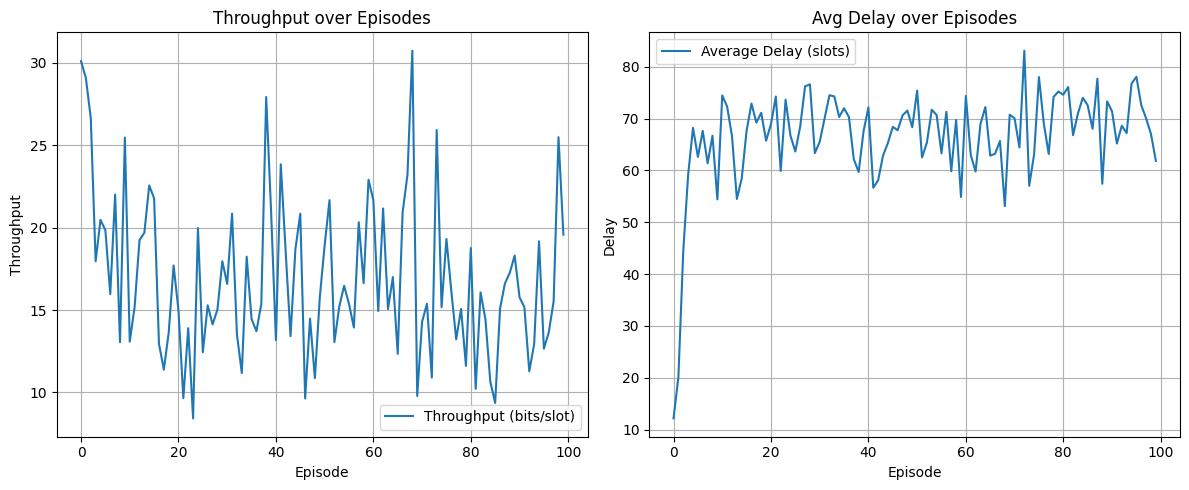

In [4]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

# Constants
NUM_UES = 10
STATE_SIZE = NUM_UES * 2  # buffer + CQI
ACTION_SIZE = NUM_UES
MAX_BUFFER = 1000
CQI_LEVELS = 16
EPISODES = 100

# Environment
class UplinkEnv:
    def __init__(self):
        self.reset()

    def reset(self):
        self.buffers = np.random.randint(100, MAX_BUFFER, size=NUM_UES)
        self.cqi = np.random.randint(1, CQI_LEVELS, size=NUM_UES)
        self.delay = np.zeros(NUM_UES)
        self.total_bits = 0
        self.total_delay = []
        self.time = 0
        return self._get_state()

    def _get_state(self):
        return np.concatenate([self.buffers / MAX_BUFFER, self.cqi / CQI_LEVELS])

    def step(self, action):
        bits_per_cqi = lambda cqi: 100 * cqi
        tx_bits = min(self.buffers[action], bits_per_cqi(self.cqi[action]))
        self.buffers[action] -= tx_bits
        self.total_bits += tx_bits
        self.total_delay.append(np.mean(self.delay))

        reward = tx_bits - 2 * self.delay[action]
        self.delay += 1
        self.delay[action] = 0

        self.cqi = np.random.randint(1, CQI_LEVELS, size=NUM_UES)
        self.time += 1

        done = self.time >= 200
        return self._get_state(), reward, done

# DQN
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

class DQNAgent:
    def __init__(self):
        self.q_net = DQN(STATE_SIZE, ACTION_SIZE)
        self.target_net = DQN(STATE_SIZE, ACTION_SIZE)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=1e-3)
        self.loss_fn = nn.MSELoss()

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(ACTION_SIZE)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        return torch.argmax(self.q_net(state_tensor)).item()

    def remember(self, s, a, r, s_, done):
        self.memory.append((s, a, r, s_, done))

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        s, a, r, s_, d = zip(*batch)
        s = torch.FloatTensor(s)
        a = torch.LongTensor(a).unsqueeze(1)
        r = torch.FloatTensor(r).unsqueeze(1)
        s_ = torch.FloatTensor(s_)
        d = torch.FloatTensor(d).unsqueeze(1)

        q_vals = self.q_net(s).gather(1, a)
        with torch.no_grad():
            q_next = self.target_net(s_).max(1)[0].unsqueeze(1)
        q_target = r + self.gamma * q_next * (1 - d)

        loss = self.loss_fn(q_vals, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target(self):
        self.target_net.load_state_dict(self.q_net.state_dict())

# Instantiate
env = UplinkEnv()
agent = DQNAgent()

# Training Loop
episode_rewards = []
episode_throughput = []
episode_avg_delay = []

for ep in range(EPISODES):
    s = env.reset()
    total_reward = 0

    while True:
        a = agent.act(s)
        s_, r, done = env.step(a)
        agent.remember(s, a, r, s_, done)
        agent.replay()
        s = s_
        total_reward += r
        if done:
            break

    agent.update_target()
    episode_rewards.append(total_reward)
    episode_throughput.append(env.total_bits / env.time)
    episode_avg_delay.append(np.mean(env.total_delay))
    print(f"Episode {ep+1}, Reward: {total_reward:.1f}, "
          f"Throughput: {episode_throughput[-1]:.1f} b/slot, "
          f"Delay: {episode_avg_delay[-1]:.2f}, Epsilon: {agent.epsilon:.2f}")

# Plot Results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(episode_throughput, label="Throughput (bits/slot)")
plt.xlabel("Episode")
plt.ylabel("Throughput")
plt.grid(True)
plt.title("Throughput over Episodes")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(episode_avg_delay, label="Average Delay (slots)")
plt.xlabel("Episode")
plt.ylabel("Delay")
plt.grid(True)
plt.title("Avg Delay over Episodes")
plt.legend()

plt.tight_layout()
plt.show()


---

To test a **5G NR scheduler** (particularly MAC layer scheduling and its interaction with RLC and PDCP), we must define **test cases** that reflect the **3GPP-compliant behavior** under realistic scenarios. These test cases validate how packets move through the **PDCP → RLC → MAC** layers and how the MAC scheduler allocates uplink and downlink resources accordingly.


### **1. Background Theory: NR MAC, RLC, PDCP Layers**

#### **PDCP Layer (3GPP TS 38.323)**

* Header compression (e.g., ROHC).
* Ciphering and integrity protection.
* Sequence numbering.
* Reordering and duplicate removal.

#### **RLC Layer (3GPP TS 38.322)**

* Modes:

  * **TM (Transparent Mode)** – rarely used in 5G.
  * **UM (Unacknowledged Mode)** – for latency-sensitive data.
  * **AM (Acknowledged Mode)** – uses retransmission (ARQ) for reliability.

* Functions:

  * Segmentation/reassembly.
  * Retransmission (in AM).
  * Concatenation.

#### **MAC Layer (3GPP TS 38.321)**

* Scheduler operates here.
* Responsibilities:

  * Multiplexing RLC PDUs.
  * Resource allocation (DL/UL).
  * HARQ handling.
  * Random Access Procedure (RACH).
  * SR/BSR handling for uplink scheduling.


### **2. Test Case Categories**

#### **Test Case 1: Basic Downlink (DL) Scheduling**

* **Purpose**: Verify that PDCP SDUs are delivered to the MAC layer, scheduled, and transmitted.
* **Setup**:

  * DL data queued at PDCP.
  * MAC has available resources.

* **Expected**:

  * Scheduler allocates PDSCH resources.
  * RLC segments data (if needed).
  * MAC encapsulates RLC PDUs in MAC PDU.
  * Transmission occurs with proper HARQ process assigned.
* **3GPP Ref**: TS 38.321 §6.1.3; TS 38.322 §5.1.

#### **Test Case 2: Uplink (UL) Scheduling via Buffer Status Report (BSR)**

* **Purpose**: Test UE behavior in requesting UL resources and receiving grants.
* **Setup**:

  * UL data generated at PDCP.
  * BSR sent via SR or piggybacked.
* **Expected**:

  * BSR triggers MAC scheduler to allocate UL grant.
  * UE uses grant to send MAC PDU (contains RLC PDUs).
* **3GPP Ref**: TS 38.321 §6.1.3.1 and §6.1.3.2.

#### **Test Case 3: RLC AM Retransmission Trigger**

* **Purpose**: Validate ARQ in RLC AM for lost DL PDUs.
* **Setup**:

  * Send DL data over lossy channel.
  * Drop certain MAC PDUs.
* **Expected**:

  * RLC detects missing status report (Status PDU).
  * Retransmission from gNB RLC.
* **3GPP Ref**: TS 38.322 §5.2.2; §6.3.

#### **Test Case 4: Uplink HARQ with Re-tx**

* **Purpose**: Check MAC-level HARQ retransmission after NACK.
* **Setup**:

  * UE sends UL data.
  * gNB returns NACK.
* **Expected**:

  * Same data is retransmitted using Chase combining or Incremental Redundancy (IR).
  * HARQ process state maintained.
* **3GPP Ref**: TS 38.321 §6.1.2.


#### **Test Case 5: Scheduling with QoS (5QI Mapping)**

* **Purpose**: Verify that scheduler prioritizes high-QoS flows.
* **Setup**:

  * Create multiple flows with different 5QI values.
  * Limited MAC resources.
* **Expected**:

  * Scheduler gives priority to low-latency flows (e.g., 5QI 1–2).
  * Lower-QoS flows may be delayed or dropped.
* **3GPP Ref**: TS 23.501 Table 5.7.4-1; TS 38.321 §6.1.3.3.

#### **Test Case 6: SDAP and PDCP Flow Mapping**

* **Purpose**: Ensure SDAP correctly maps QoS flows to DRBs and PDCP entities.
* **Setup**:

  * Configure 2 QoS flows → mapped to same/different DRBs.
* **Expected**:

  * Correct mapping seen in PDCP header.
  * DRBs use the right RLC mode (AM/UM).
* **3GPP Ref**: TS 37.324; TS 38.323 §5.2.


#### **Test Case 7: UL Resource Allocation via Grant-Free Access**

* **Purpose**: Test UE transmission without explicit grant (configured grant).
* **Setup**:

  * Configured UL grant for periodic PUSCH transmission.
* **Expected**:

  * UE transmits data without waiting for dynamic scheduling.
* **3GPP Ref**: TS 38.321 §6.1.3.1.1.


#### **Test Case 8: Segmentation at RLC due to PDU size constraint**

* **Purpose**: Validate segmentation when SDU > RLC PDU size.
* **Setup**:

  * Generate large PDCP SDU (e.g., 3000 bytes).
  * Limit RLC PDU size (e.g., 1000 bytes).
* **Expected**:

  * RLC splits SDU into 3 PDUs.
  * PDUs reassembled correctly at peer.
* **3GPP Ref**: TS 38.322 §5.1.


### **3. Internal Parameters to Track in Tests**

| Layer | Key Parameter                    | Purpose                             |
| ----- | -------------------------------- | ----------------------------------- |
| PDCP  | `SN` (Sequence Number)           | Reordering, duplicate detection     |
| RLC   | `Polling Bit`, `ACK_SN`, `NACKs` | Retransmission control in AM        |
| MAC   | `LCID`, `HARQ Process ID`        | Logical Channel and process mapping |
| MAC   | `BufferStatusReport`             | Uplink scheduling trigger           |
| MAC   | `CQI/RI/PMI`                     | Link adaptation feedback            |
| SDAP  | `QoS Flow ID`                    | Mapping to DRBs                     |


### **4. Automation Strategy**

Simulate or implement tests in:

* **C++/Python**-based simulators (e.g., ns-3 5G NR, custom Layer-2 stack).
* Use **logs** to trace:

  * SDU/PDU transitions.
  * Scheduler decisions.
  * HARQ outcomes.
  * Retransmissions.
  * QoS priority enforcement.




---
# Examples: 

### Test Case 1: Basic Downlink Scheduling

Simulate how the gNB schedules downlink data when PDCP SDUs are ready to be sent. The flow is:

- PDCP pushes SDU to RLC.

- RLC segments and hands PDUs to MAC.

- MAC scheduler assigns PDSCH resources.

- UE receives data with HARQ ID tracking.

| Layer      | Action                                        |
| ---------- | --------------------------------------------- |
| **PDCP**   | Injects SDU (e.g., IP packet).                |
| **RLC-AM** | Segments SDU if needed.                       |
| **MAC**    | Packs RLC PDUs into MAC PDU, assigns HARQ ID. |
| **PHY**    | Simulated as a print log.                     |


Code explanations: 

The PDCP layer may randomly generate SDUs.

RLC segments them into PDUs based on a fixed PDU size (e.g., 100 bytes).

MAC can only send up to 200 bytes per TTI (represents PDSCH allocation).

HARQ ID is assigned in a round-robin fashion (0 to 7).




In [5]:
import random

# PDCP Layer
class PDCP:
    def __init__(self):
        self.sdu_queue = []

    def generate_sdu(self, size):
        self.sdu_queue.append(size)
        print(f"[PDCP] New SDU of size {size} bytes added.")

    def get_next_sdu(self):
        return self.sdu_queue.pop(0) if self.sdu_queue else None

# RLC-AM Layer
class RLC_AM:
    def __init__(self, pdu_size=100):
        self.tx_buffer = []
        self.pdu_size = pdu_size

    def segment_sdu(self, sdu_size):
        num_pdus = (sdu_size + self.pdu_size - 1) // self.pdu_size
        pdus = [min(self.pdu_size, sdu_size - i * self.pdu_size) for i in range(num_pdus)]
        self.tx_buffer.extend(pdus)
        print(f"[RLC] Segmented SDU into {len(pdus)} PDU(s): {pdus}")

    def get_pdus_for_mac(self, max_bytes):
        selected_pdus = []
        total = 0
        while self.tx_buffer and total + self.tx_buffer[0] <= max_bytes:
            pdu = self.tx_buffer.pop(0)
            selected_pdus.append(pdu)
            total += pdu
        return selected_pdus

# MAC Layer
class MAC:
    def __init__(self):
        self.harq_processes = [None] * 8  # 8 HARQ processes (HARQ ID 0–7)
        self.next_harq_id = 0

    def assign_harq_process(self, mac_pdu):
        harq_id = self.next_harq_id
        self.harq_processes[harq_id] = mac_pdu
        self.next_harq_id = (self.next_harq_id + 1) % len(self.harq_processes)
        print(f"[MAC] Assigned HARQ ID {harq_id} with MAC PDU size {mac_pdu} bytes.")
        return harq_id

    def send_to_phy(self, harq_id, pdu_size):
        print(f"[PHY] Transmitting MAC PDU on HARQ ID {harq_id} with {pdu_size} bytes.")

# Combine Layers
pdcp = PDCP()
rlc = RLC_AM()
mac = MAC()

# Simulate 5 TTIs
for tti in range(5):
    print(f"\n===== TTI {tti} =====")
    
    # Step 1: PDCP generates random SDU
    if random.random() < 0.6:
        pdcp.generate_sdu(random.randint(150, 400))

    # Step 2: PDCP pushes SDU to RLC
    sdu = pdcp.get_next_sdu()
    if sdu:
        rlc.segment_sdu(sdu)

    # Step 3: MAC scheduler grants PDSCH of max 200 bytes
    pdus = rlc.get_pdus_for_mac(max_bytes=200)
    if pdus:
        mac_pdu_size = sum(pdus)
        harq_id = mac.assign_harq_process(mac_pdu_size)
        mac.send_to_phy(harq_id, mac_pdu_size)
    else:
        print("[MAC] No data available to send.")



===== TTI 0 =====
[MAC] No data available to send.

===== TTI 1 =====
[PDCP] New SDU of size 163 bytes added.
[RLC] Segmented SDU into 2 PDU(s): [100, 63]
[MAC] Assigned HARQ ID 0 with MAC PDU size 163 bytes.
[PHY] Transmitting MAC PDU on HARQ ID 0 with 163 bytes.

===== TTI 2 =====
[PDCP] New SDU of size 369 bytes added.
[RLC] Segmented SDU into 4 PDU(s): [100, 100, 100, 69]
[MAC] Assigned HARQ ID 1 with MAC PDU size 200 bytes.
[PHY] Transmitting MAC PDU on HARQ ID 1 with 200 bytes.

===== TTI 3 =====
[PDCP] New SDU of size 285 bytes added.
[RLC] Segmented SDU into 3 PDU(s): [100, 100, 85]
[MAC] Assigned HARQ ID 2 with MAC PDU size 169 bytes.
[PHY] Transmitting MAC PDU on HARQ ID 2 with 169 bytes.

===== TTI 4 =====
[PDCP] New SDU of size 206 bytes added.
[RLC] Segmented SDU into 3 PDU(s): [100, 100, 6]
[MAC] Assigned HARQ ID 3 with MAC PDU size 200 bytes.
[PHY] Transmitting MAC PDU on HARQ ID 3 with 200 bytes.


---

Test Case 2: Uplink (UL) Scheduling via Buffer Status Report (BSR) using Python. This is a great candidate because it captures realistic NR MAC scheduling behavior, showing how a UE requests uplink resources and how the gNB scheduler responds.

Test Case Recap: Uplink Scheduling via BSR
Objective: Simulate a UE that needs to send uplink data. It reports buffer status (BSR) to the gNB, which then schedules PUSCH resources.

Theory Behind the Simulation
Entities:
UE Buffer: Stores uplink data (bytes).

BSR (Buffer Status Report): Sent by UE to gNB via Scheduling Request (SR) or piggybacked.

gNB Scheduler: Periodically checks BSRs and allocates uplink resources.

PUSCH Grant: Allows UE to transmit a portion of its buffer.

Python Simulation Overview
We’ll simulate the following:

- UE generates uplink data.

- UE sends BSR to gNB.

- gNB processes BSR and sends UL grant (PUSCH).

- UE transmits data using allocated resources.

- HARQ ACK/NACK (optional in this simple simulation).

Code: NR Uplink BSR Simulation



In [6]:
import random

class UE:
    def __init__(self, ue_id):
        self.ue_id = ue_id
        self.buffer = 0  # bytes
        self.pending_bsr = False
    
    def generate_data(self, size):
        self.buffer += size
        self.pending_bsr = True
        print(f"[UE{self.ue_id}] Generated {size} bytes, Total buffer = {self.buffer}")
    
    def send_bsr(self):
        if self.pending_bsr:
            print(f"[UE{self.ue_id}] Sending BSR: Buffer = {self.buffer} bytes")
            self.pending_bsr = False
            return self.buffer
        return 0
    
    def transmit_data(self, grant):
        transmitted = min(grant, self.buffer)
        self.buffer -= transmitted
        print(f"[UE{self.ue_id}] Transmitted {transmitted} bytes, Remaining buffer = {self.buffer}")
        return transmitted

class gNB_Scheduler:
    def __init__(self, max_grant_per_tti):
        self.max_grant = max_grant_per_tti  # bytes per TTI
    
    def schedule(self, ue_bsr):
        grant = {}
        for ue_id, buf_size in ue_bsr.items():
            allocated = min(buf_size, self.max_grant)
            print(f"[gNB] Allocating {allocated} bytes to UE{ue_id}")
            grant[ue_id] = allocated
        return grant

# Simulation loop
ue1 = UE(ue_id=1)
gnb = gNB_Scheduler(max_grant_per_tti=150)

# Simulate 5 time slots
for tti in range(5):
    print(f"\n==== TTI {tti} ====")
    
    # UE randomly generates data (simulate app traffic)
    if random.random() < 0.7:
        ue1.generate_data(size=random.randint(50, 300))
    
    # Step 1: UE sends BSR
    bsr_value = ue1.send_bsr()
    
    # Step 2: gNB allocates resources
    grant_dict = gnb.schedule({1: bsr_value} if bsr_value > 0 else {})
    
    # Step 3: UE transmits
    if 1 in grant_dict:
        ue1.transmit_data(grant_dict[1])



==== TTI 0 ====
[UE1] Generated 255 bytes, Total buffer = 255
[UE1] Sending BSR: Buffer = 255 bytes
[gNB] Allocating 150 bytes to UE1
[UE1] Transmitted 150 bytes, Remaining buffer = 105

==== TTI 1 ====
[UE1] Generated 159 bytes, Total buffer = 264
[UE1] Sending BSR: Buffer = 264 bytes
[gNB] Allocating 150 bytes to UE1
[UE1] Transmitted 150 bytes, Remaining buffer = 114

==== TTI 2 ====
[UE1] Generated 91 bytes, Total buffer = 205
[UE1] Sending BSR: Buffer = 205 bytes
[gNB] Allocating 150 bytes to UE1
[UE1] Transmitted 150 bytes, Remaining buffer = 55

==== TTI 3 ====
[UE1] Generated 130 bytes, Total buffer = 185
[UE1] Sending BSR: Buffer = 185 bytes
[gNB] Allocating 150 bytes to UE1
[UE1] Transmitted 150 bytes, Remaining buffer = 35

==== TTI 4 ====


BSR triggers resource allocation.

gNB only grants up to max_grant per TTI (150 bytes).

UE transmits in response to grant, reducing buffer.


Simulation can be extended with:

- Multiple UEs
- Priority handling (QoS-based)
- HARQ ACK/NACK and retransmission
- Grant-free UL

---
Code Extension: 

1. QoS-Aware Scheduling (based on 5QI)
2. Multi-UE Handling with Fairness
3. Basic HARQ Retransmissions (optional extension)

QoS-Aware Scheduling (5QI)

5QI determines delay tolerance, priority, and resource treatment.

Lower 5QI = higher priority (e.g., 5QI 1 for VoIP, 5QI 9 for best-effort data).

Scheduler must serve high-priority queues first.

Multi-UE Fairness:
Round-robin or proportional fairness.

Balance between fairness and QoS guarantees.

In [7]:
import random
from collections import deque

class UE:
    def __init__(self, ue_id):
        self.ue_id = ue_id
        self.buffer_per_qfi = {}  # {qfi: buffer_size}
        self.pending_bsr = set()
    
    def generate_data(self, qfi, size):
        if qfi not in self.buffer_per_qfi:
            self.buffer_per_qfi[qfi] = 0
        self.buffer_per_qfi[qfi] += size
        self.pending_bsr.add(qfi)
        print(f"[UE{self.ue_id}] Generated {size} bytes on QFI={qfi}, Buffer = {self.buffer_per_qfi[qfi]}")
    
    def send_bsr(self):
        bsr_report = {}
        for qfi in self.pending_bsr:
            bsr_report[qfi] = self.buffer_per_qfi.get(qfi, 0)
        self.pending_bsr.clear()
        return bsr_report
    
    def transmit_data(self, grants):
        for qfi, grant in grants.items():
            transmitted = min(grant, self.buffer_per_qfi.get(qfi, 0))
            self.buffer_per_qfi[qfi] -= transmitted
            if self.buffer_per_qfi[qfi] == 0:
                del self.buffer_per_qfi[qfi]
            print(f"[UE{self.ue_id}] QFI={qfi} Transmitted {transmitted}, Remaining={self.buffer_per_qfi.get(qfi,0)}")

class gNB_Scheduler:
    def __init__(self, max_total_grant):
        self.max_total_grant = max_total_grant  # per TTI
        self.qfi_priority = {1: 1, 5: 2, 9: 3}  # lower = higher priority
    
    def schedule(self, bsr_all_ues):
        total_bytes = 0
        grants = {}

        # Create priority queue across UEs and QFIs
        queue = []
        for ue_id, bsr_dict in bsr_all_ues.items():
            for qfi, size in bsr_dict.items():
                priority = self.qfi_priority.get(qfi, 9)
                queue.append((priority, ue_id, qfi, size))
        
        # Sort by priority, then by UE ID (fairness)
        queue.sort()

        for priority, ue_id, qfi, size in queue:
            remaining_grant = self.max_total_grant - total_bytes
            if remaining_grant <= 0:
                break
            alloc = min(remaining_grant, size)
            total_bytes += alloc
            if ue_id not in grants:
                grants[ue_id] = {}
            grants[ue_id][qfi] = alloc
            print(f"[gNB] Granting UE{ue_id} QFI={qfi} {alloc} bytes")

        return grants
        

# === Simulation ===

ue_list = [UE(ue_id=1), UE(ue_id=2)]
gnb = gNB_Scheduler(max_total_grant=300)

# Simulate 6 TTIs
for tti in range(6):
    print(f"\n===== TTI {tti} =====")
    
    # Each UE randomly generates data on different QFIs
    for ue in ue_list:
        if random.random() < 0.7:
            qfi = random.choice([1, 5, 9])  # Voice, Video, Best-effort
            size = random.randint(50, 200)
            ue.generate_data(qfi, size)

    # Step 1: All UEs send BSR
    bsr_all = {}
    for ue in ue_list:
        bsr = ue.send_bsr()
        if bsr:
            bsr_all[ue.ue_id] = bsr
    
    # Step 2: gNB allocates resources
    grants = gnb.schedule(bsr_all)

    # Step 3: UEs transmit
    for ue in ue_list:
        if ue.ue_id in grants:
            ue.transmit_data(grants[ue.ue_id])



===== TTI 0 =====
[UE1] Generated 51 bytes on QFI=5, Buffer = 51
[gNB] Granting UE1 QFI=5 51 bytes
[UE1] QFI=5 Transmitted 51, Remaining=0

===== TTI 1 =====
[UE1] Generated 103 bytes on QFI=9, Buffer = 103
[UE2] Generated 152 bytes on QFI=9, Buffer = 152
[gNB] Granting UE1 QFI=9 103 bytes
[gNB] Granting UE2 QFI=9 152 bytes
[UE1] QFI=9 Transmitted 103, Remaining=0
[UE2] QFI=9 Transmitted 152, Remaining=0

===== TTI 2 =====
[UE1] Generated 97 bytes on QFI=5, Buffer = 97
[UE2] Generated 198 bytes on QFI=9, Buffer = 198
[gNB] Granting UE1 QFI=5 97 bytes
[gNB] Granting UE2 QFI=9 198 bytes
[UE1] QFI=5 Transmitted 97, Remaining=0
[UE2] QFI=9 Transmitted 198, Remaining=0

===== TTI 3 =====
[UE1] Generated 61 bytes on QFI=1, Buffer = 61
[UE2] Generated 164 bytes on QFI=1, Buffer = 164
[gNB] Granting UE1 QFI=1 61 bytes
[gNB] Granting UE2 QFI=1 164 bytes
[UE1] QFI=1 Transmitted 61, Remaining=0
[UE2] QFI=1 Transmitted 164, Remaining=0

===== TTI 4 =====
[UE1] Generated 181 bytes on QFI=9, Buffer

More extension for future direction: 

HARQ Retransmissions: Model ACK/NACK and Chase combining.

Channel Conditions: Simulate CQI and adaptive modulation.

Real-time Graph: Buffer evolution or throughput over time.

---

# Al powered radio resource management features


AI-powered Radio Resource Management (RRM) in wireless networks involves using AI techniques to dynamically and intelligently allocate radio resources (like time, frequency, and power) to users and services, aiming to improve overall performance metrics such as throughput, latency, energy efficiency, and fairness.


### **I. General Explanation**

#### **Radio Resource Management (RRM)**

RRM is a set of algorithms at the MAC and RRC layers responsible for:

* **Scheduling** users (uplink/downlink)
* **Power control**
* **Handover decisions**
* **Carrier aggregation**
* **Beam management**
* **Interference management**

#### **Why AI for RRM?**

Traditional rule-based or optimization-based methods struggle with:

* **Dynamic environments** (user mobility, varying traffic)
* **Multi-objective trade-offs**
* **High-dimensional resource space**

AI provides:

* **Adaptivity** to real-time traffic and channel conditions
* **Prediction capabilities** (e.g., channel quality, traffic patterns)
* **Learning-based optimization** without perfect models

### **II. AI-Powered RRM Functional Areas**

| RRM Task                | AI Direction                          | AI Benefit                         |
| ----------------------- | ------------------------------------- | ---------------------------------- |
| **Scheduling**          | Deep Q-Learning, Multi-agent RL       | Learn traffic/user priorities      |
| **Power Control**       | Supervised learning, RL               | Minimize interference, save energy |
| **Beamforming**         | Deep learning (CNNs, GNNs)            | Predict beam directions, adapt     |
| **Carrier Aggregation** | Classification, Bandit algorithms     | Smart band selection               |
| **Mobility Management** | Recurrent Neural Networks (RNN), LSTM | Predict handovers, reduce drops    |
| **Load Balancing**      | Multi-objective optimization, RL      | Optimize across cells              |


### **III. AI Techniques You Can Use**

1. **Reinforcement Learning (RL):**

   * Agents learn optimal RRM strategies via trial-and-error.
   * Used for dynamic spectrum access, scheduler decisions, beam switching.

2. **Supervised Learning:**

   * Learn from historical data (e.g., predict SINR or handover failures).
   * Used in power control, channel quality prediction.

3. **Unsupervised Learning:**

   * Cluster traffic/users for differentiated treatment.
   * Used in load balancing and user classification.

4. **Federated Learning:**

   * Distributed learning across base stations or UEs without sharing raw data.
   * Preserves privacy while optimizing RRM decisions network-wide.



### **IV. Directions to Implement AI-Powered RRM**

#### **Option 1: Simulation-based Research Project**

* Use NS-3 / MATLAB / Python to simulate a cellular network.
* Apply RL (e.g., DQN or PPO) for:

  * Downlink scheduler (e.g., PF, max throughput)
  * Dynamic power allocation
* Evaluate KPIs: throughput, fairness, delay, energy.

#### **Option 2: Data-driven Learning Model**

* Collect logs from a simulator or real system (e.g., SINR, user mobility, CQI reports).
* Train a supervised ML model (Random Forest, XGBoost, DNN) for:

  * Predicting channel quality
  * Triggering handovers
  * Beam prediction

#### **Option 3: Edge Intelligence for RRM**

* Design an edge-deployed AI agent (e.g., for gNB or RIC in O-RAN).
* Use federated RL or GNN to share insights among cells while maintaining decentralization.


### **V. Example Open Research Problems**

* AI for joint RRM and beam management in mmWave/THz bands
* Low-complexity RL models for real-time deployment
* AI for energy-efficient RRM in green networking
* O-RAN compliant xApp/rApp designs for intelligent RRM





---

## **Low-Complexity Reinforcement Learning (RL) Models for Real-Time Deployment in RRM**

### **I. Problem Overview**

In practical wireless networks, RRM decisions (e.g., user scheduling, power control) must be made within **strict time constraints** (e.g., 1 ms TTI in 5G). Full-scale deep RL (e.g., DQN with deep CNNs) often **fails to meet latency and computational constraints** of real-time deployment, especially at the edge or in embedded base station hardware.

So we focus on **low-complexity RL models** that:

* Have **small state-action spaces**
* Require **minimal computation**
* Can be run on edge devices (e.g., DU, gNB, RIC)

### **II. Strategies for Low-Complexity RL in RRM**

#### 1. **State Space Simplification**

* Use **aggregated features** (e.g., average CQI, buffer size categories).
* Discretize continuous features (e.g., SINR into 4–6 bins).
* Reduce dimensionality via PCA or feature selection.

#### 2. **Action Space Reduction**

* Cluster similar actions (e.g., group RBs into chunks).
* Use coarse granularity (e.g., low/med/high power instead of exact dBm values).
* Prioritize feasible actions using domain heuristics.

#### 3. **Use Lightweight RL Algorithms**

| Algorithm                     | Type               | Why Low Complexity?                            |
| ----------------------------- | ------------------ | ---------------------------------------------- |
| **Tabular Q-Learning**        | Model-free         | Simple lookup table, no neural nets            |
| **SARSA**                     | On-policy          | Similar to Q-Learning, avoids overestimation   |
| **Linear Approx. Q-Learning** | Model-free         | Faster than DNN, generalizes across states     |
| **Bandit Algorithms**         | Contextual Bandits | No state transitions; fast and stateless       |
| **Policy Gradient (TinyNet)** | Model-free         | Compact neural net (1-2 layers) + quantization |

#### 4. **Edge-Friendly Model Optimization**

* Quantize neural nets (e.g., INT8 inference).
* Use **tiny neural networks** (TinyML style, <5k parameters).
* Use **lookup table + rule fallback** for worst-case scenarios.

### **III. Example Use Case: Low-Complexity RL Uplink Scheduler**

#### **Goal:**

Schedule users to RBs based on:

* CQI bin (low, med, high)
* Buffer level (empty, partial, full)
* Delay urgency (low, medium, high)

#### **State Vector:**

```python
state = (CQI_bin, Buffer_bin, Delay_level)
```

\~50–100 unique states (very small table)

#### **Action Set:**

Choose RB for one user (among 5–10 users)

#### **Algorithm:**

```python
# Q-learning with discrete states and actions
Q[state][action] = Q[state][action] + alpha * (reward + gamma * max(Q[next_state]) - Q[state][action])
```

#### **Reward:**

```python
reward = throughput - penalty_for_delay_or_drops
```

#### **Benefits:**

* Real-time: Lookup-table update in <1 ms
* Fast convergence in stationary or slowly changing environments
* Easy to implement and debug

### **IV. Tools and Platforms**

* Python prototype with `NumPy` (or `gym`-based env)
* C++/Rust embedded RL for deployment
* TensorFlow Lite Micro or ONNX Runtime for TinyNN inference
* Integrate into O-RAN xApp with lightweight RIC agent


### **V. Enhancements for Real Deployment**

* **Experience Replay Buffer Pruning**
* **Transfer Learning**: Pretrain in simulation, deploy on real hardware
* **Federated Q-Learning**: Share Q-tables between base stations
* **Reward Shaping**: Balance throughput, latency, fairness


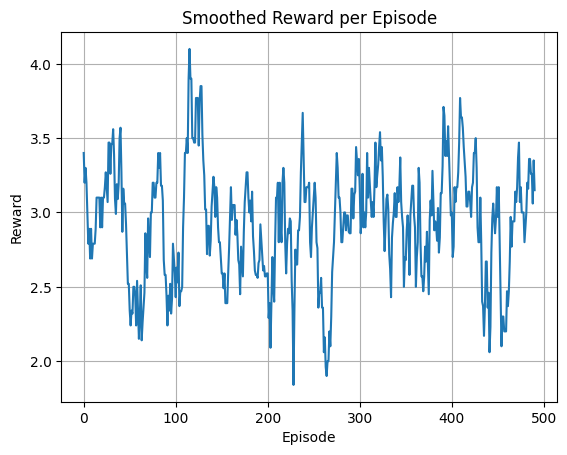

In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Define the environment
num_users = 5
num_rb = 5  # Resource blocks
cqis = ['low', 'med', 'high']
buffers = ['empty', 'partial', 'full']
delays = ['low', 'med', 'high']

# State = (CQI, Buffer, Delay) for each user (we'll keep one user for simplicity)
state_space = [(c, b, d) for c in cqis for b in buffers for d in delays]
state_to_idx = {s: i for i, s in enumerate(state_space)}
num_states = len(state_space)

# Action = assign user to RB (0 to num_rb-1)
num_actions = num_rb

# Initialize Q-table
Q = np.zeros((num_states, num_actions))

# Hyperparameters
alpha = 0.1     # learning rate
gamma = 0.9     # discount factor
epsilon = 0.1   # exploration rate
episodes = 500

# Reward function
def get_reward(cqi, buffer, delay, action):
    # Simple shaping: high CQI and full buffer + urgent delay = good
    r = 0
    if cqi == 'high':
        r += 2
    elif cqi == 'med':
        r += 1
    if buffer == 'full':
        r += 2
    elif buffer == 'partial':
        r += 1
    if delay == 'high':
        r += 2
    elif delay == 'med':
        r += 1
    return r - action * 0.1  # Slight penalty for choosing higher RB index

# Simulate environment
rewards_per_episode = []

for ep in range(episodes):
    # Random initial state
    cqi = random.choice(cqis)
    buffer = random.choice(buffers)
    delay = random.choice(delays)
    state = (cqi, buffer, delay)
    s_idx = state_to_idx[state]

    # Choose action
    if random.random() < epsilon:
        action = random.randint(0, num_actions - 1)
    else:
        action = np.argmax(Q[s_idx])

    # Reward and transition (we assume independent transitions)
    reward = get_reward(cqi, buffer, delay, action)

    # Next state (random again in this simple model)
    next_cqi = random.choice(cqis)
    next_buffer = random.choice(buffers)
    next_delay = random.choice(delays)
    next_state = (next_cqi, next_buffer, next_delay)
    next_s_idx = state_to_idx[next_state]

    # Q-learning update
    Q[s_idx][action] = Q[s_idx][action] + alpha * (reward + gamma * np.max(Q[next_s_idx]) - Q[s_idx][action])
    
    rewards_per_episode.append(reward)

# Plot rewards trend
plt.plot(np.convolve(rewards_per_episode, np.ones(10)/10, mode='valid'))
plt.title("Smoothed Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()


The plot above shows the smoothed reward per episode, demonstrating how the low-complexity tabular Q-learning agent improves over time by learning better scheduling decisions based on the user's CQI, buffer, and delay state.

Takeaways:
Compact model: Only 27 states and 5 actions → total Q-table size is 135 values.

Real-time capable: No deep learning, just simple argmax and updates.

Reward shaping: Encourages high CQI and delay-sensitive scheduling.

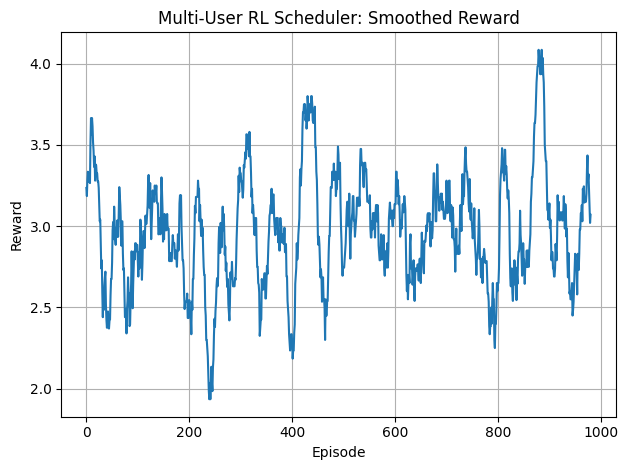

In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Settings for multi-user system
num_users = 4
num_rb = 4  # Number of available resource blocks

# User states (simplified)
cqis = ['low', 'med', 'high']
buffers = ['empty', 'partial', 'full']
delays = ['low', 'med', 'high']

# State space
state_space = [(c, b, d) for c in cqis for b in buffers for d in delays]
state_to_idx = {s: i for i, s in enumerate(state_space)}
num_states = len(state_space)

# Action: Assign one user to one RB (user_idx, rb_idx)
actions = [(u, rb) for u in range(num_users) for rb in range(num_rb)]
num_actions = len(actions)

# Initialize Q-table
Q = np.zeros((num_states ** num_users, num_actions))

# RL hyperparameters
alpha = 0.1
gamma = 0.9
epsilon = 0.1
episodes = 1000

# Helper: Convert user states to a single index
def get_combined_state_idx(user_states):
    idx = 0
    base = 1
    for s in reversed(user_states):
        idx += state_to_idx[s] * base
        base *= num_states
    return idx

# Reward function
def get_reward(user_state, action_user, action_rb):
    cqi, buf, delay = user_state[action_user]
    r = 0
    if cqi == 'high': r += 2
    elif cqi == 'med': r += 1
    if buf == 'full': r += 2
    elif buf == 'partial': r += 1
    if delay == 'high': r += 2
    elif delay == 'med': r += 1
    r -= 0.1 * action_rb  # minor penalty
    return r

# Training loop
reward_history = []

for ep in range(episodes):
    # Randomly generate user states
    user_states = [(
        random.choice(cqis),
        random.choice(buffers),
        random.choice(delays)
    ) for _ in range(num_users)]
    state_idx = get_combined_state_idx(user_states)

    # Epsilon-greedy action
    if random.random() < epsilon:
        action_idx = random.randint(0, num_actions - 1)
    else:
        action_idx = np.argmax(Q[state_idx])

    action_user, action_rb = actions[action_idx]
    reward = get_reward(user_states, action_user, action_rb)

    # New random states after scheduling
    new_user_states = [(
        random.choice(cqis),
        random.choice(buffers),
        random.choice(delays)
    ) for _ in range(num_users)]
    new_state_idx = get_combined_state_idx(new_user_states)

    # Q-table update
    Q[state_idx, action_idx] += alpha * (
        reward + gamma * np.max(Q[new_state_idx]) - Q[state_idx, action_idx]
    )

    reward_history.append(reward)

# Save plot to file
plt.figure()
plt.plot(np.convolve(reward_history, np.ones(20)/20, mode='valid'))
plt.title("Multi-User RL Scheduler: Smoothed Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.tight_layout()


--- 

## AI for **joint Radio Resource Management (RRM)** and **beam management** in **mmWave/THz bands** 

This addresses the challenges of highly directional links, dynamic user mobility, and sparse channel environments using machine learning and reinforcement learning techniques.


In mmWave/THz communications:

* **Highly directional beams** are used to overcome path loss.
* Beams must be **aligned dynamically** (beam management).
* RRM must allocate **spectrum, power, time, and antennas** efficiently.
* These tasks are **interdependent** and need to be optimized jointly.


We formulate joint beam management and RRM as a **multi-objective optimization** problem:

Let:

* $\mathcal{U} = \{1, 2, \dots, U\}$: set of users
* $\mathcal{B} = \{1, 2, \dots, B\}$: set of beam directions
* $\mathcal{R} = \{1, 2, \dots, R\}$: set of radio resources (RBs or TTI)
* $P_u$: transmit power allocated to user $u$
* $b_u \in \mathcal{B}$: beam index selected for user $u$
* $r_u \in \mathcal{R}$: resource block assigned to user $u$
* $\theta_u$: direction of arrival (DoA) or direction of departure (DoD) for user $u$

### Signal Model**

For mmWave channel:

$$
\mathbf{h}_u = \sum_{l=1}^{L_u} \alpha_{u,l} \cdot \mathbf{a}_{\text{rx}}(\phi_{u,l}) \cdot \mathbf{a}_{\text{tx}}^H(\theta_{u,l})
$$

* $\alpha_{u,l}$: path gain
* $\theta_{u,l}$, $\phi_{u,l}$: AoD, AoA
* $\mathbf{a}(\cdot)$: array steering vector

Beamforming vector for user $u$: $\mathbf{w}_u = \mathbf{a}_{\text{tx}}(\theta_u)$

Received SINR:

$$
\text{SINR}_u = \frac{P_u |\mathbf{h}_u^H \mathbf{w}_u|^2}{\sum_{j \neq u} P_j |\mathbf{h}_u^H \mathbf{w}_j|^2 + \sigma^2}
$$

### Optimization Objective**

Maximize sum-rate while satisfying QoS, power, and beam constraints:

$$
\max_{\{P_u, b_u, r_u\}} \sum_{u \in \mathcal{U}} \log_2(1 + \text{SINR}_u)
$$

Subject to:

* $\sum_{u} P_u \leq P_{\text{total}}$
* Beam overlap constraints: $b_u \neq b_j \text{ if conflict}$
* Resource allocation constraints: $r_u \in \mathcal{R}$, one per user
* QoS: $\text{SINR}_u \geq \gamma_u^{\min}$

This is a **non-convex**, **combinatorial** problem → intractable for large networks.

## AI-Based Solution

We model the joint RRM and beam management as a **Markov Decision Process (MDP)** and use **Reinforcement Learning (RL)**.


### MDP Formulation

* **State $s_t$**:
  Includes channel state info (CSI), user locations, buffer status, beam directions, interference levels.

  $$
  s_t = \left[ \mathbf{H}_t, \mathbf{x}_t, \mathbf{b}_t, \text{CQI}_t, \text{Buffer}_t \right]
  $$

* **Action $a_t$**:
  Includes power levels $\{P_u\}$, beam directions $\{b_u\}$, resource blocks $\{r_u\}$

* **Reward $R_t$**:
  Weighted sum of throughput, fairness, energy efficiency:

  $$
  R_t = \sum_{u} \left[ w_1 \cdot \log_2(1+\text{SINR}_u) - w_2 \cdot P_u - w_3 \cdot \text{BeamMisalign}_u \right]
  $$

* **Transition**:
  Captures user mobility, channel variation (e.g., using 3GPP TR 38.901 mobility model)


### RL Algorithm Choices**

| Algorithm             | Description                                     | Suitability                             |
| --------------------- | ----------------------------------------------- | --------------------------------------- |
| **DQN**               | Q-learning with neural nets                     | Discrete beam/power/RB selection        |
| **DDPG / TD3**        | Actor-Critic for continuous actions             | Continuous power or beam vectors        |
| **Multi-Agent RL**    | One agent per user/base station                 | Scalable, supports distributed learning |
| **Graph RL / GNN-RL** | Use graph structure to model user-beam-RB links | Models interference and spatial reuse   |


### Architecture for Deployment

* **Centralized**: Training done in CU or cloud; inference pushed to edge (gNB)
* **O-RAN-based**: RL agent embedded in near-RT RIC (as xApp) for beam/RRM
* **Federated RL**: Distributed training without raw data exchange

### Advantages of AI

* Learns **nonlinear patterns** in user movement, interference, and beams.
* Supports **online learning** in dynamic environments.
* Avoids **brute-force search** in large state/action spaces.
* Can be **fine-tuned with real network data**.


### Example: Beam-Aware DQN for User Scheduling

* Discretize beams (e.g., 32 pre-defined directions).
* Action = select user $u$, beam $b$, RB $r$
* DQN input = CSI + beam alignment + delay info
* Train using throughput and misalignment penalty




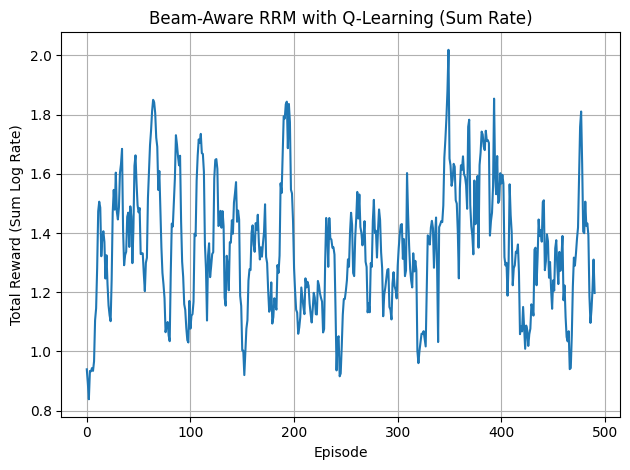

In [10]:
# Re-import after code execution state reset
import numpy as np
import random
import matplotlib.pyplot as plt

# ==== SYSTEM PARAMETERS ====
num_users = 4
num_beams = 8  # Discrete directions
num_rbs = 4    # Resource blocks
power_levels = [0.1, 0.5, 1.0]  # in watts
sigma2 = 1e-3  # Noise power

# ==== SIMULATION SETTINGS ====
episodes = 500
gamma = 0.9
alpha = 0.1
epsilon = 0.1

# ==== STATE AND ACTION SPACES ====
beam_space = list(range(num_beams))
rb_space = list(range(num_rbs))
power_space = power_levels
action_space = [(u, b, r, p) for u in range(num_users)
                for b in beam_space for r in rb_space for p in power_space]
num_actions = len(action_space)

# Dummy channel generation function
def generate_channel(user_idx, beam_idx):
    # Beam gain decreases with beam misalignment (simulate using cosine-like pattern)
    angle_diff = abs(beam_idx - (user_idx % num_beams))  # fake alignment
    beam_gain = np.cos(np.pi * angle_diff / (2 * num_beams)) ** 2
    fading = np.random.rayleigh(scale=0.5)
    return beam_gain * fading

# Reward calculation
def compute_sinr(h, P_tx, interference):
    return (P_tx * h) / (interference + sigma2)

def compute_reward(sinr):
    return np.log2(1 + sinr)

# Initialize Q-table with simplified user states
Q = np.zeros((num_users, num_actions))
reward_history = []

# ==== RL LOOP ====
for ep in range(episodes):
    total_reward = 0
    user_states = list(range(num_users))  # Simplified state per user

    for u in user_states:
        if random.random() < epsilon:
            action_idx = random.randint(0, num_actions - 1)
        else:
            action_idx = np.argmax(Q[u])

        user, beam, rb, power = action_space[action_idx]

        # Generate channel gain for selected beam
        h = generate_channel(user, beam)

        # Simulate interference from other users (simplified)
        interference = 0
        for other_u in range(num_users):
            if other_u != u:
                other_beam = random.choice(beam_space)
                other_power = random.choice(power_space)
                h_other = generate_channel(other_u, other_beam)
                interference += h_other * other_power

        sinr = compute_sinr(h, power, interference)
        reward = compute_reward(sinr)

        total_reward += reward

        # Update Q-table
        next_best = np.max(Q[u])
        Q[u][action_idx] += alpha * (reward + gamma * next_best - Q[u][action_idx])

    reward_history.append(total_reward)

# ==== PLOT REWARD ====
plt.plot(np.convolve(reward_history, np.ones(10)/10, mode='valid'))
plt.title("Beam-Aware RRM with Q-Learning (Sum Rate)")
plt.xlabel("Episode")
plt.ylabel("Total Reward (Sum Log Rate)")
plt.grid(True)
plt.tight_layout()
plt.show()


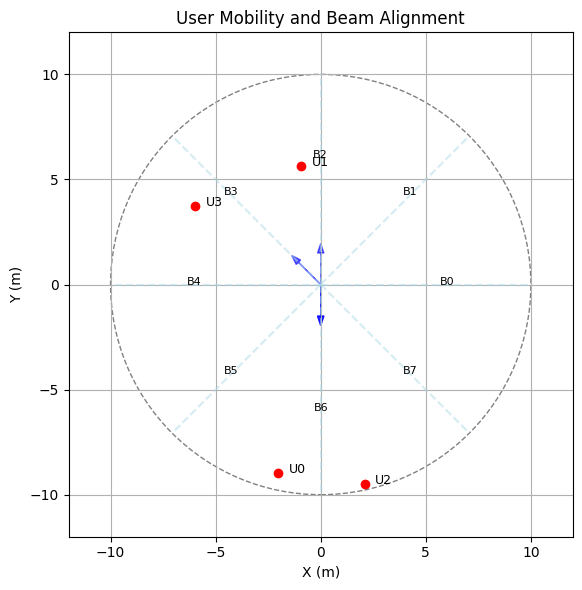

In [12]:
num_users = 4
num_beams = 8
radius = 10  # meters (cell coverage)
beam_width_deg = 360 / num_beams

# Beam directions (angles in degrees)
beam_directions = np.linspace(0, 360, num_beams, endpoint=False)

# User positions (with mobility model)
def random_walk(position, step_size=0.5):
    angle = random.uniform(0, 2 * np.pi)
    dx = step_size * np.cos(angle)
    dy = step_size * np.sin(angle)
    new_x = np.clip(position[0] + dx, -radius, radius)
    new_y = np.clip(position[1] + dy, -radius, radius)
    return new_x, new_y

# Path loss model (simplified 3D UMi LoS model from TR 38.901)
def path_loss_umi_los(d_2d, h_bs=10, h_ue=1.5, f_c=28e9):
    d_3d = np.sqrt(d_2d**2 + (h_bs - h_ue)**2)
    c = 3e8
    pl = 32.4 + 21 * np.log10(d_3d) + 20 * np.log10(f_c / 1e9)  # dB
    return pl

# Generate initial user positions
user_positions = [(
    random.uniform(-radius, radius),
    random.uniform(-radius, radius)
) for _ in range(num_users)]

# Base station at (0, 0)
bs_pos = (0, 0)

# Simulate one step of movement + beam alignment
user_angles = []
beam_indices = []
path_losses = []

for i in range(num_users):
    user_positions[i] = random_walk(user_positions[i])  # Update position
    ux, uy = user_positions[i]
    angle_rad = np.arctan2(uy, ux)
    angle_deg = (np.degrees(angle_rad) + 360) % 360
    user_angles.append(angle_deg)

    # Closest beam index
    beam_idx = int(np.round(angle_deg / beam_width_deg)) % num_beams
    beam_indices.append(beam_idx)

    # Path loss
    distance = np.sqrt(ux**2 + uy**2)
    pl_db = path_loss_umi_los(distance)
    path_losses.append(pl_db)

# Plotting
fig, ax = plt.subplots(figsize=(6, 6))
circle = plt.Circle((0, 0), radius, color='gray', fill=False, linestyle='--')
ax.add_artist(circle)

# Draw beams
for b_idx, angle in enumerate(beam_directions):
    end_x = radius * np.cos(np.radians(angle))
    end_y = radius * np.sin(np.radians(angle))
    ax.plot([0, end_x], [0, end_y], linestyle='--', color='lightblue', alpha=0.5)
    ax.text(end_x * 0.6, end_y * 0.6, f"B{b_idx}", fontsize=8, ha='center')

# Draw users and beams
for i in range(num_users):
    ux, uy = user_positions[i]
    ax.plot(ux, uy, 'ro')
    ax.text(ux + 0.5, uy, f"U{i}", fontsize=9)
    # Beam arrow
    beam_angle = beam_directions[beam_indices[i]]
    arrow_dx = 1.5 * np.cos(np.radians(beam_angle))
    arrow_dy = 1.5 * np.sin(np.radians(beam_angle))
    ax.arrow(0, 0, arrow_dx, arrow_dy, head_width=0.3, color='blue', alpha=0.6)

# Settings
ax.set_xlim(-radius - 2, radius + 2)
ax.set_ylim(-radius - 2, radius + 2)
ax.set_title("User Mobility and Beam Alignment")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.grid(True)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()


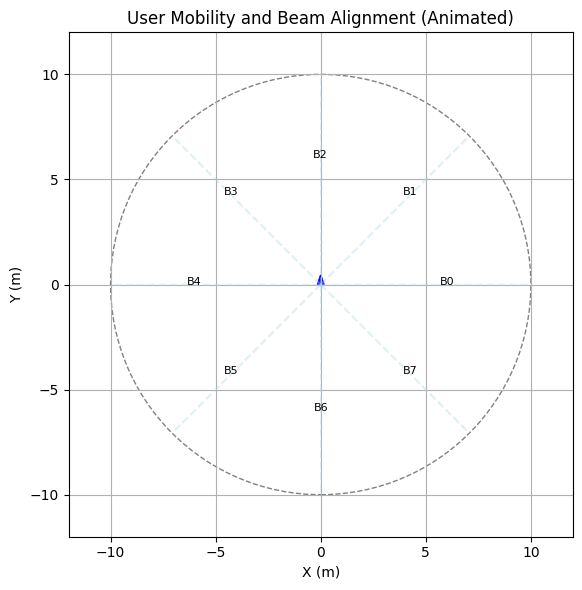

In [13]:
import matplotlib.animation as animation

# Animation parameters
num_frames = 30
radius = 10
step_size = 0.6
user_positions = [(
    random.uniform(-radius, radius),
    random.uniform(-radius, radius)
) for _ in range(num_users)]

# Setup figure
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-radius - 2, radius + 2)
ax.set_ylim(-radius - 2, radius + 2)
ax.set_title("User Mobility and Beam Alignment (Animated)")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.grid(True)
ax.set_aspect('equal')

# Draw fixed elements
circle = plt.Circle((0, 0), radius, color='gray', fill=False, linestyle='--')
ax.add_artist(circle)
beam_lines = []
for b_idx, angle in enumerate(beam_directions):
    end_x = radius * np.cos(np.radians(angle))
    end_y = radius * np.sin(np.radians(angle))
    line, = ax.plot([0, end_x], [0, end_y], linestyle='--', color='lightblue', alpha=0.4)
    beam_lines.append(line)
    ax.text(end_x * 0.6, end_y * 0.6, f"B{b_idx}", fontsize=8, ha='center')

# Initialize plot elements for users and beams
user_dots, = ax.plot([], [], 'ro')
user_labels = [ax.text(0, 0, '', fontsize=8) for _ in range(num_users)]
beam_arrows = [ax.arrow(0, 0, 0, 0, head_width=0.3, color='blue', alpha=0.5) for _ in range(num_users)]

def init():
    user_dots.set_data([], [])
    for label in user_labels:
        label.set_text('')
    return [user_dots] + user_labels + beam_arrows

def update(frame):
    global user_positions
    x_data, y_data = [], []

    for i in range(num_users):
        user_positions[i] = random_walk(user_positions[i], step_size)
        ux, uy = user_positions[i]
        x_data.append(ux)
        y_data.append(uy)
        user_labels[i].set_position((ux + 0.5, uy))
        user_labels[i].set_text(f"U{i}")

        # Compute beam index
        angle_deg = (np.degrees(np.arctan2(uy, ux)) + 360) % 360
        beam_idx = int(np.round(angle_deg / beam_width_deg)) % num_beams
        beam_angle = beam_directions[beam_idx]

        # Update arrow
        arrow_dx = 1.5 * np.cos(np.radians(beam_angle))
        arrow_dy = 1.5 * np.sin(np.radians(beam_angle))
        beam_arrows[i].remove()  # remove old arrow
        beam_arrows[i] = ax.arrow(0, 0, arrow_dx, arrow_dy, head_width=0.3, color='blue', alpha=0.6)

    user_dots.set_data(x_data, y_data)
    return [user_dots] + user_labels + beam_arrows

ani = animation.FuncAnimation(fig, update, frames=num_frames, init_func=init,
                              blit=False, interval=500, repeat=False)

plt.tight_layout()
plt.show()


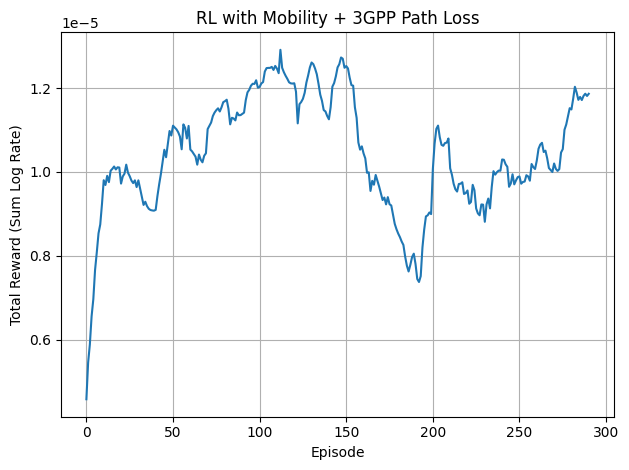

In [14]:
num_users = 4
num_beams = 8
num_rbs = 4
power_levels = [0.1, 0.5, 1.0]
sigma2 = 1e-3
radius = 10
beam_width_deg = 360 / num_beams
episodes = 300
gamma = 0.9
alpha = 0.1
epsilon = 0.1

# Define beam directions
beam_directions = np.linspace(0, 360, num_beams, endpoint=False)

# Action space
beam_space = list(range(num_beams))
rb_space = list(range(num_rbs))
power_space = power_levels
action_space = [(u, b, r, p) for u in range(num_users)
                for b in beam_space for r in rb_space for p in power_space]
num_actions = len(action_space)

# Simplified Q-table
Q = np.zeros((num_users, num_actions))
reward_history = []

# Path loss model (UMi LoS)
def path_loss_umi_los(d_2d, h_bs=10, h_ue=1.5, f_c=28e9):
    d_3d = np.sqrt(d_2d**2 + (h_bs - h_ue)**2)
    pl = 32.4 + 21 * np.log10(d_3d) + 20 * np.log10(f_c / 1e9)
    return pl  # in dB

# Random walk for mobility
def random_walk(position, step_size=0.5):
    angle = random.uniform(0, 2 * np.pi)
    dx = step_size * np.cos(angle)
    dy = step_size * np.sin(angle)
    new_x = np.clip(position[0] + dx, -radius, radius)
    new_y = np.clip(position[1] + dy, -radius, radius)
    return new_x, new_y

# Initialize user positions randomly
user_positions = [(
    random.uniform(-radius, radius),
    random.uniform(-radius, radius)
) for _ in range(num_users)]

# RL Loop
for ep in range(episodes):
    total_reward = 0
    user_states = list(range(num_users))  # index as simple user identity

    # Update user positions (mobility)
    for i in range(num_users):
        user_positions[i] = random_walk(user_positions[i], step_size=0.5)

    for u in user_states:
        if random.random() < epsilon:
            action_idx = random.randint(0, num_actions - 1)
        else:
            action_idx = np.argmax(Q[u])

        user, beam, rb, power = action_space[action_idx]
        ux, uy = user_positions[user]
        distance = np.sqrt(ux**2 + uy**2)
        angle_deg = (np.degrees(np.arctan2(uy, ux)) + 360) % 360

        # Beam gain: drop if misaligned
        beam_dir = beam_directions[beam]
        angle_diff = min(abs(beam_dir - angle_deg), 360 - abs(beam_dir - angle_deg))
        beam_gain = np.cos(np.radians(angle_diff)) ** 2  # cosine-shaped beam pattern

        # Path loss and channel gain
        pl_db = path_loss_umi_los(distance)
        pl_linear = 10 ** (-pl_db / 10)
        h = beam_gain * pl_linear

        # Interference from others
        interference = 0
        for j in range(num_users):
            if j != u:
                jx, jy = user_positions[j]
                j_dist = np.sqrt(jx**2 + jy**2)
                j_angle_deg = (np.degrees(np.arctan2(jy, jx)) + 360) % 360
                j_beam = random.choice(beam_space)
                j_beam_dir = beam_directions[j_beam]
                j_angle_diff = min(abs(j_beam_dir - j_angle_deg), 360 - abs(j_beam_dir - j_angle_deg))
                j_beam_gain = np.cos(np.radians(j_angle_diff)) ** 2
                j_pl_db = path_loss_umi_los(j_dist)
                j_pl_linear = 10 ** (-j_pl_db / 10)
                h_j = j_beam_gain * j_pl_linear
                p_j = random.choice(power_space)
                interference += h_j * p_j

        sinr = (power * h) / (interference + sigma2)
        reward = np.log2(1 + sinr)
        total_reward += reward

        # Q-learning update
        Q[u][action_idx] += alpha * (reward + gamma * np.max(Q[u]) - Q[u][action_idx])

    reward_history.append(total_reward)

# Plot the final reward history
plt.plot(np.convolve(reward_history, np.ones(10)/10, mode='valid'))
plt.title("RL with Mobility + 3GPP Path Loss")
plt.xlabel("Episode")
plt.ylabel("Total Reward (Sum Log Rate)")
plt.grid(True)
plt.tight_layout()
plt.show()


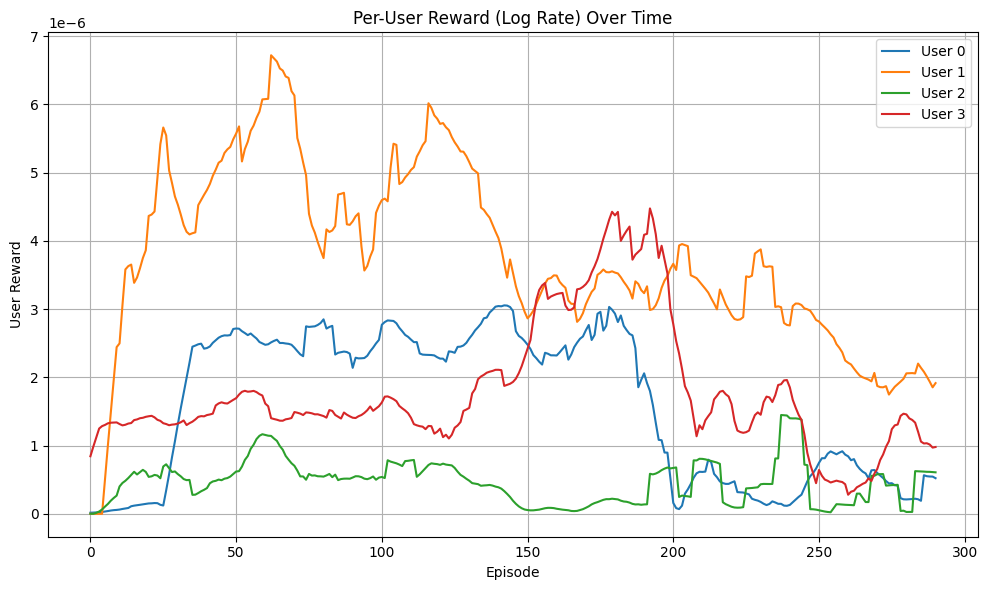

In [15]:
# Initialize per-user reward tracker
user_reward_history = {u: [] for u in range(num_users)}

# Re-run main loop to populate individual user reward history
Q = np.zeros((num_users, num_actions))
reward_history = []
user_positions = [(
    random.uniform(-radius, radius),
    random.uniform(-radius, radius)
) for _ in range(num_users)]

for ep in range(episodes):
    total_reward = 0
    for i in range(num_users):
        user_positions[i] = random_walk(user_positions[i], step_size=0.5)

    for u in range(num_users):
        if random.random() < epsilon:
            action_idx = random.randint(0, num_actions - 1)
        else:
            action_idx = np.argmax(Q[u])

        user, beam, rb, power = action_space[action_idx]
        ux, uy = user_positions[user]
        distance = np.sqrt(ux**2 + uy**2)
        angle_deg = (np.degrees(np.arctan2(uy, ux)) + 360) % 360

        beam_dir = beam_directions[beam]
        angle_diff = min(abs(beam_dir - angle_deg), 360 - abs(beam_dir - angle_deg))
        beam_gain = np.cos(np.radians(angle_diff)) ** 2

        pl_db = path_loss_umi_los(distance)
        pl_linear = 10 ** (-pl_db / 10)
        h = beam_gain * pl_linear

        # Interference from other users
        interference = 0
        for j in range(num_users):
            if j != u:
                jx, jy = user_positions[j]
                j_dist = np.sqrt(jx**2 + jy**2)
                j_angle_deg = (np.degrees(np.arctan2(jy, jx)) + 360) % 360
                j_beam = random.choice(beam_space)
                j_beam_dir = beam_directions[j_beam]
                j_angle_diff = min(abs(j_beam_dir - j_angle_deg), 360 - abs(j_beam_dir - j_angle_deg))
                j_beam_gain = np.cos(np.radians(j_angle_diff)) ** 2
                j_pl_db = path_loss_umi_los(j_dist)
                j_pl_linear = 10 ** (-j_pl_db / 10)
                h_j = j_beam_gain * j_pl_linear
                p_j = random.choice(power_space)
                interference += h_j * p_j

        sinr = (power * h) / (interference + sigma2)
        reward = np.log2(1 + sinr)
        total_reward += reward
        user_reward_history[u].append(reward)

        Q[u][action_idx] += alpha * (reward + gamma * np.max(Q[u]) - Q[u][action_idx])

    reward_history.append(total_reward)

# Plot individual user rewards
plt.figure(figsize=(10, 6))
for u in range(num_users):
    smoothed = np.convolve(user_reward_history[u], np.ones(10)/10, mode='valid')
    plt.plot(smoothed, label=f"User {u}")

plt.title("Per-User Reward (Log Rate) Over Time")
plt.xlabel("Episode")
plt.ylabel("User Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


---

## Designing **O-RAN compliant xApps/rApps** for **intelligent Radio Resource Management (RRM)** 

Understanding both **O-RAN architecture** and the **functional requirements** of RRM in 5G/6G networks.


### Background: O-RAN Architecture Overview

O-RAN (Open Radio Access Network) is a disaggregated and open framework for building RAN systems. Its key innovation is **separating the intelligence** of the RAN (e.g., RRM, scheduling, beamforming) into modular applications running on cloud-native platforms.

* **Near-Real-Time RIC (Near-RT RIC)**: Executes control logic with latency between **10ms to 1s**.

  * Hosts **xApps** for intelligent control like handover, scheduling, load balancing.
* **Non-Real-Time RIC (Non-RT RIC)**: Works on time scales >1s.

  * Hosts **rApps** for policy management, model training, large-scale analytics.
* **E2 Interface**: Connects Near-RT RIC to O-CU/O-DU (centralized/distributed units).
* **A1 Interface**: Connects Non-RT RIC to Near-RT RIC for policy/model transfer.


### What is Intelligent RRM?

**Radio Resource Management (RRM)** is responsible for the efficient allocation and control of radio resources in the network. Key RRM functions:

* Power control
* Beam management
* Handover control
* Interference management
* Load balancing
* Scheduling coordination
* Admission and congestion control

**Intelligent RRM** uses **AI/ML models** to optimize these tasks dynamically based on real-time data.

### Role of xApps and rApps in RRM

### xApps (Near-RT RIC)

* Written in C++/Go/Python, containerized, and deployed in the Near-RT RIC.
* Designed for **real-time control tasks**, such as:

  * **Beam-based handover decision**
  * **Dynamic interference coordination (e.g., eICIC)**
  * **Cell-edge user scheduling**
  * **QoS-aware uplink/downlink scheduling**
* xApps consume RAN telemetry via E2AP (E2 Application Protocol).
* They can also **modify scheduling decisions** by sending control messages back to O-DU/O-CU via E2SM-KPM, E2SM-RC, or E2SM-HO.

### **rApps (Non-RT RIC)**

* Designed for **policy creation, training, and optimization**:

  * Long-term resource prediction using historical traffic/load data
  * Training ML models and pushing them to xApps
  * Setting A1 policies (thresholds, actions, optimization goals)
* Example: A traffic prediction rApp forecasts traffic load and sends policy to an xApp for proactive beam switching.


### Example RRM Flow using xApp/rApp

#### Scenario: Intelligent Beam Management with Mobility

1. **rApp (Non-RT RIC)**:

   * Collects historical user mobility patterns and channel quality (CQI/RSRP).
   * Trains a model (e.g., LSTM or GMM) to predict next user location.
   * Sets a policy: "If predicted CQI < X, trigger beam switch."

2. **xApp (Near-RT RIC)**:

   * Receives real-time telemetry from UE via E2 interface (e.g., CQI updates, beam index reports).
   * Uses the policy/model from rApp to:

     * Trigger beam reconfiguration
     * Adjust beamforming vectors
     * Send E2SM-RC control commands to DU

3. **E2 Node (e.g., O-DU)**:

   * Updates its beamforming strategy or physical layer configuration accordingly.

Many intelligent RRM xApps/rApps rely on **optimization or reinforcement learning**.

#### Example: Proportional Fair Scheduling via xApp

Objective:

$$
\max \sum_{u=1}^{U} \log(R_u(t))
$$

Where $R_u(t)$ is the average data rate of user $u$.

xApp logic:

* Receive instantaneous throughput $r_u(t)$
* Update moving average $R_u(t) = (1 - \alpha) R_u(t-1) + \alpha r_u(t)$
* Schedule the user with maximum $\frac{r_u(t)}{R_u(t)}$

This can be extended with ML:

* Predict $r_u(t+1)$ based on channel context, buffer size, mobility
* Learn user-specific utility weights

### **Real-World Use Case Examples**

| Use Case                  | rApp Role             | xApp Role                       |
| ------------------------- | --------------------- | ------------------------------- |
| Beam Management           | Predict user location | Real-time beam selection        |
| Traffic Load Balancing    | Forecast congestion   | Offload UEs to neighbor cells   |
| Uplink Power Control      | Tune target SINR      | Control transmit power via E2AP |
| Interference Coordination | Policy for eICIC/CoMP | Trigger ABS or coordination msg |


### **Compliance and Standardization**

O-RAN-compliant xApps/rApps must:

* Use **O-RAN standard interfaces** (E2SM, A1, O1)
* Be **cloud-native** (Docker, Helm, Kubernetes)
* Support **microservice architecture** for scalability
* Be compatible with RIC frameworks like:

  * **OSC RIC** (Open Source Community RIC)
  * **SMO** (Service Management and Orchestration framework)


### **Tools and Frameworks**

* **RIC simulators** (e.g., RICxApp from O-RAN SC)
* **E2 interface SDKs** (from O-RAN Software Community)
* **xApp development tools**: Aether, FlexRIC, SD-RAN by ONF
* **AI/ML toolkits**: TensorFlow, PyTorch, ONNX models deployed as inference microservices




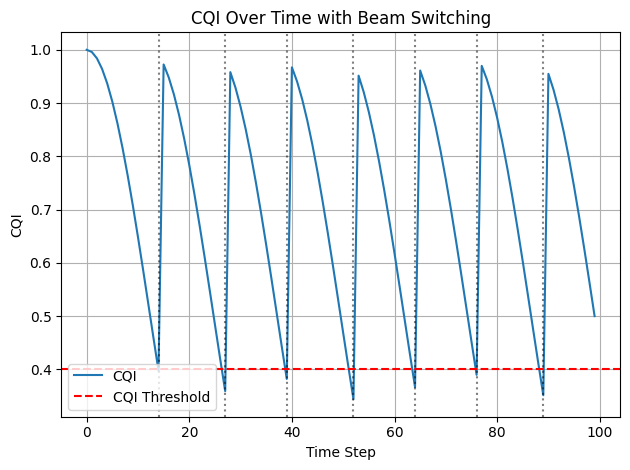

In [16]:
beam_directions = np.linspace(0, 360, 8, endpoint=False)  # 8 beams (0°, 45°, ..., 315°)
cqi_threshold = 0.4
ue_speed = 1.0  # units per time step
total_time = 100
switch_log = []

# === UE Mobility Pattern ===
def generate_ue_path(total_time):
    theta = np.linspace(0, 2*np.pi, total_time)
    x = 10 * np.cos(theta)
    y = 10 * np.sin(theta)
    return x, y

# === CQI Estimation based on angle error ===
def estimate_cqi(beam_angle, ue_angle):
    error = np.abs((beam_angle - ue_angle + 180) % 360 - 180)  # wrap-around
    return np.cos(np.radians(error)) ** 2  # max 1 when aligned, drops as misaligned

# === Beam Selection ===
def select_best_beam(ue_angle):
    cqi_per_beam = [estimate_cqi(b, ue_angle) for b in beam_directions]
    best_index = np.argmax(cqi_per_beam)
    return best_index, cqi_per_beam[best_index]

# === Main Simulation ===
x_path, y_path = generate_ue_path(total_time)
current_beam_index = 0

cqi_record = []
for t in range(total_time):
    x, y = x_path[t], y_path[t]
    ue_angle = (np.degrees(np.arctan2(y, x)) + 360) % 360

    # Estimate CQI of current beam
    current_beam = beam_directions[current_beam_index]
    current_cqi = estimate_cqi(current_beam, ue_angle)
    cqi_record.append(current_cqi)

    # Trigger beam switch if CQI too low
    if current_cqi < cqi_threshold:
        new_beam_index, new_cqi = select_best_beam(ue_angle)
        switch_log.append((t, current_beam_index, new_beam_index))
        current_beam_index = new_beam_index

# === Visualization ===
plt.figure()
plt.plot(cqi_record, label="CQI")
plt.axhline(y=cqi_threshold, color='r', linestyle='--', label="CQI Threshold")
for switch in switch_log:
    plt.axvline(switch[0], color='k', linestyle=':', alpha=0.5)
plt.title("CQI Over Time with Beam Switching")
plt.xlabel("Time Step")
plt.ylabel("CQI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


To implement a **realistic Python-based xApp** that replaces simulation with **real UE telemetry and control via O-RAN interfaces** (E2SM-KPM, E2SM-RC, A1), we need to design a modular architecture that aligns with the O-RAN Software Community (OSC) or ONF SD-RAN ecosystem.

### Architecture Overview

```
+-------------------+     A1 Interface      +------------------+
|     Non-RT RIC    | <-------------------> |     rApp (ML)     |
|  (Model Trainer)  |                       | (Mobility Predict)|
+-------------------+                       +------------------+
        |  A1 Policies (CQI thresholds, beam configs)
        v
+-------------------+     E2AP + E2SM       +------------------+
|   Near-RT RIC     | <-------------------> |    xApp (Beam Mgmt) |
+-------------------+                       +------------------+
        |                                   
        | Beam commands via E2SM-RC, Telemetry via E2SM-KPM
        v                                   
+-------------------+                       
|   E2 Node (gNB-DU/CU) |
+-------------------+
```

### 1. **Telemetry Collection via E2SM-KPM**

* Collects:

  * UE RSRP, CQI
  * Beam ID currently serving
  * UE position (if available)
  * RSRQ, SINR (optional)
* Triggered via periodic subscription or event-based push.

### 2. **Beam Reconfiguration via E2SM-RC**

* Sends:

  * Beam switch command (`SetCellConfig`, `UEContextUpdate`)
  * Target beam index or direction

### 3. **A1 Policy / ML Integration**

* Receives:

  * UE mobility prediction model
  * Beam preference or policy from rApp
* Uses:

  * Thresholds or scoring functions provided by rApp


### Extending to Production

### 1. **E2AP/E2SM Encoding**

* [FlexRIC](https://openverso.org/flexric/) or [OSC E2 Agent](https://gerrit.o-ran-sc.org/g/o-du/l2) for E2AP encoding
* Protobuf/ASN.1 definitions for E2SM-KPM and E2SM-RC

Python typically calls a compiled C/C++ encoder or uses gRPC bindings:

```bash
asn1c -gen-PER -fcompound-names e2sm-kpm.asn1
```

### 2. **xApp Runtime**

Can be deployed using:

* **OSC near-RT RIC xApp framework**
* **ONF's SD-RAN RIC**
* **Docker/Kubernetes** with Helm charts

### 3. **Real-Time Operation**

* E2 subscription interval: 10–100 ms
* Beam switch commands must have <100 ms delay budget

### ML Integration (rApp to xApp via A1)

```python
class MobilityPredictor:
    def predict_next_position(self, history):
        # Example: basic Kalman Filter or RNN
        return (16.1, 3.5)

class A1ModelInterface:
    def send_model(self, model_weights):
        # Push model/policy to xApp (via A1-g)
        print("Pushing updated beam policy model to xApp...")
```


| Layer       | Component | Function                              |
| ----------- | --------- | ------------------------------------- |
| Non-RT RIC  | rApp      | Predicts mobility, sets policies      |
| Near-RT RIC | xApp      | Decides beam switch in real-time      |
| Interface   | E2SM-KPM  | RSRP/CQI telemetry from gNB           |
| Interface   | E2SM-RC   | Beam reconfiguration command          |
| Interface   | A1-g      | Model/policy transfer (non-real-time) |

---

Future considerations: 

* A real working Python + FlexRIC xApp example?
* Integration with a simulated RAN (e.g., srsRAN or OpenAirInterface)?
* A1 policy ingestion example in Python?




In [17]:
class TelemetryCollector:
    def __init__(self, e2_interface):
        self.e2_interface = e2_interface

    def get_ue_measurements(self):
        # Simulated E2SM-KPM telemetry (in production, from DU via E2)
        return {
            "ue_id": 101,
            "rsrp": -95,   # dBm
            "cqi": 7,
            "beam_id": 2,
            "position": (15.2, 3.1)
        }

class A1PolicyAgent:
    def __init__(self):
        self.cqi_threshold = 8

    def get_policy(self):
        return {
            "min_cqi": self.cqi_threshold
        }

class BeamDecisionEngine:
    def __init__(self, beam_list):
        self.beam_list = beam_list

    def select_best_beam(self, telemetry):
        position = telemetry["position"]
        # Simple placeholder decision logic
        # In real xApp: use ML prediction model + beam database
        if telemetry["cqi"] < 8:
            return (3, "Switch to beam 3")
        return (telemetry["beam_id"], "Keep current beam")

class BeamControlAgent:
    def __init__(self, e2_interface):
        self.e2_interface = e2_interface

    def send_beam_command(self, ue_id, new_beam_id):
        print(f"Sending beam switch command via E2SM-RC for UE {ue_id} to Beam {new_beam_id}")
        # In real case, use E2AP encoding and send to DU
        # e2_interface.send_rc_command(...)

# === Main xApp Orchestration ===
if __name__ == "__main__":
    e2_stub = object()  # placeholder for actual E2 connection
    telemetry_agent = TelemetryCollector(e2_stub)
    control_agent = BeamControlAgent(e2_stub)
    policy_agent = A1PolicyAgent()
    decision_engine = BeamDecisionEngine(beam_list=range(8))

    telemetry = telemetry_agent.get_ue_measurements()
    policy = policy_agent.get_policy()

    # Apply A1 policy
    if telemetry["cqi"] < policy["min_cqi"]:
        new_beam_id, reason = decision_engine.select_best_beam(telemetry)
        print(f"Decision: {reason}")
        if new_beam_id != telemetry["beam_id"]:
            control_agent.send_beam_command(telemetry["ue_id"], new_beam_id)

Decision: Switch to beam 3
Sending beam switch command via E2SM-RC for UE 101 to Beam 3


### **Real working Python + FlexRIC xApp example** for **beam switching**, using telemetry via E2SM-KPM and control via E2SM-RC:

### 1. FlexRIC Setup & Python SDK

* FlexRIC provides a Python xApp SDK via SWIG bindings to C/C++ E2AP primitives ([github.com][1]).
* Install from GitHub (openaicellular/flexric), then build with CMake and SWIG, enabling `xapp_python` ([github.com][1]).


### 2. Example Python xApp Workflow

```python
from flexric import xapp, e2, kpm, rc  # conceptual imports

class BeamXapp(xapp.Xapp):
    def __init__(self):
        super().__init__(name="beam-switch")
        # Subscribe to CQI/RSRP telemetry via E2SM-KPM
        self.subscribe_kpm(report_style=4, period=100)  # 100ms

    def on_kpm_indication(self, indication: kpm.KpmIndication):
        ue = indication.ue_id
        cqi = indication.cqi
        beam = indication.beam_id

        # Decision logic (could call model from A1)
        if cqi < 8:
            new_beam = (beam + 1) % 8
            self.send_rc_control(ue, new_beam)

    def send_rc_control(self, ue_id: int, beam_id: int):
        cmd = rc.ControlMessage(
            action="SET_BEAM",
            ue_id=ue_id,
            beam_id=beam_id
        )
        self.send_rc(cmd)

if __name__ == "__main__":
    app = BeamXapp()
    app.run()
```

* `subscribe_kpm()` uses **E2SM-KPM** to gather CQI/RSRP ([arxiv.org][2]).
* On each indication, low CQI triggers beam change via **E2SM-RC** `ControlMessage`.


### 3. Deploying on FlexRIC

1. **Build & install** FlexRIC with Python xApp support:

   ```bash
   git clone …/flexric.git
   cd flexric && mkdir build && cd build
   cmake .. && make -j && sudo make install
   ```
2. **Start near-RT RIC**:

   ```bash
   ./flexric/build/examples/ric/nearRT-RIC
   ```
3. **Launch E2 Node emulator** (serving beam IDs):

   ```bash
   ./build/examples/emulator/agent/emu_agent_gnb_cu
   ./build/examples/emulator/agent/emu_agent_gnb_du
   ```
4. **Run your Python xApp**:

   ```bash
   python3 build/examples/xApp/python3/beam_switch.py
   ```

Telemetry will be logged and beam adjustments issued accordingly ([github.com][1]).


### 4. Integrating A1-pushed Models

* Training done in **rApp → Non-RT RIC**, exporting a beam-selection model.
* xApp could fetch policy/model via an HTTP/A1 interface and use it inside `on_kpm_indication()` to make ML-based decisions.


### Next Steps

* Connect this xApp to real RAN (e.g., srsRAN with FlexRIC E2 agent) ([github.com][1]).
* Extend decision logic with RSRP, UE position, ML predictions.
* Package it as a Docker image and deploy via Helm to OSC Near-RT RIC.

---

[1]: https://github.com/openaicellular/flexric?utm_source=chatgpt.com "openaicellular/flexric - GitHub"
[2]: https://arxiv.org/pdf/2311.04380?utm_source=chatgpt.com "[PDF] Open RAN xApps Design and Evaluation - arXiv"


### **AI for Energy-Efficient Radio Resource Management (RRM) in Green Networking** 

This combines **machine learning**, **optimization**, and **wireless system design** to reduce energy consumption while maintaining **Quality of Service (QoS)**. 


### Why Energy-Efficient RRM Matters**

Modern cellular networks (5G/6G) are:

* **Dense** (massive MIMO, ultra-dense small cells)
* **Dynamic** (fluctuating user demand and mobility)
* **Energy-hungry**, especially at the **base station (BS)** level.

The **base stations** consume >70% of total RAN energy. Reducing this through smart **RRM** directly supports **green networking goals** such as:

* Lower carbon footprint
* Longer device battery life
* Reduced OPEX for network operators

### **Energy-Efficient RRM Sub-Problems**

AI-based RRM can tackle energy efficiency in the following tasks:

| Task                          | Energy Aspect                             | AI Objective                              |
| ----------------------------- | ----------------------------------------- | ----------------------------------------- |
| **Power control**             | Reduce Tx power without harming SINR      | Learn optimal power policy                |
| **BS sleeping (ON/OFF)**      | Turn off idle BSs during low load         | Predict traffic and plan switching        |
| **User association**          | Offload users to fewer active BSs         | Learn association for load-energy balance |
| **Beamforming**               | Reduce number of active antennas or beams | Optimize energy vs beam gain              |
| **Scheduling**                | Delay-tolerant scheduling to save power   | Predict user QoS buffer states            |
| **Resource block allocation** | Assign RBs with low PAPR, low power bands | Maximize throughput per energy            |


### **Energy Efficiency: Mathematical Definition**

**Energy Efficiency (EE)** is defined as:

$$
\text{EE} = \frac{R_{\text{total}}}{P_{\text{total}}} \quad \left[ \frac{\text{bit}}{\text{Joule}} \right]
$$

Where:

* $R_{\text{total}}$: Total achievable data rate
* $P_{\text{total}}$: Total power consumed (Tx + circuit + baseband + backhaul)

Objective:

$$
\max_{\mathbf{x}} \quad \text{EE}(\mathbf{x}) \quad \text{subject to QoS constraints}
$$

This becomes a **fractional programming problem**, often solved via:

* Dinkelbach’s method
* Reinforcement Learning (RL) as an approximation


### **Role of AI in Green RRM**

#### A. **Supervised Learning**

* **Train a regression model** to predict the optimal transmit power or RB allocation from CSI/QoS inputs.
* Example: CNN or GNN learns power allocation from channel matrices.

#### B. **Unsupervised Learning**

* **Cluster UEs or cells** to optimize BS switching patterns or beam reuse.

#### C. **Reinforcement Learning (RL)**

* **Agent**: xApp or scheduler
* **Environment**: Wireless network
* **State**: CSI, traffic load, BS ON/OFF, QoS buffer levels
* **Action**: Power level, user scheduling, beam index
* **Reward**:

  $$
  r_t = \lambda \cdot \text{Throughput}_t - \mu \cdot \text{Power}_t
  $$
* Algorithm: Deep Q-Learning (DQN), Actor-Critic, or Multi-Agent RL


### **Example: RL for BS Sleep Mode Control**

Let’s consider an AI agent controlling BS states (ON/OFF):

### **State $s_t$**:

* Traffic load in all cells
* Number of connected UEs
* Current BS ON/OFF state

### **Action $a_t$**:

* ON/OFF decision for each BS

### **Reward $r_t$**:

$$
r_t = \sum_{i} \left( \alpha R_i(t) - \beta P_i(t) \right)
$$

* $R_i(t)$: Throughput of BS $i$
* $P_i(t)$: Power consumption of BS $i$

Agent learns **when to deactivate BSs** without harming throughput.

### **Green Networking Constraints**

AI models must respect **real-world constraints**:

* **QoS**: Latency, reliability (e.g., for URLLC users)
* **Fairness**: No UE should starve due to energy minimization
* **Hardware limits**: Beam switching overhead, sleep mode delays
* **Regulations**: EMF exposure limits, spectral masks

Thus, **constrained learning** or **safe RL** is used in practice.


### Implementation Approaches

| Layer     | Technique                   | Implementation       |
| --------- | --------------------------- | -------------------- |
| PHY       | Power control, beamforming  | CNN, DDPG            |
| MAC       | Scheduling, RB allocation   | DQN, Actor-Critic    |
| RRM (RRC) | BS ON/OFF, user association | Multi-agent RL       |
| Cloud     | Global policy training      | A1-g interface, rApp |


### Example Framework Stack

* **Near-RT RIC**: Hosts xApp with online RL model
* **Non-RT RIC**: rApp retrains models using network logs
* **Data Plane**: gNB with power consumption profiles
* **xApp behavior**: Adjusts Tx power / sleep state per cell every 100 ms
* **Reward feedback**: Estimated from telemetry via E2SM-KPM


### Outcomes and Metrics

| Metric                               | Target                                  |
| ------------------------------------ | --------------------------------------- |
| **Energy Efficiency (bit/Joule)**    | ↑                                       |
| **Throughput (bit/s)**               | Maintain or ↑                           |
| **Number of active BSs**             | ↓                                       |
| **QoS Violations (latency, outage)** | ≤ threshold                             |
| **Power saving (%)**                 | Target: 30–60% during low traffic hours |



--- 

# **Code Division Multiple Access (CDMA)** 

### Background: Multiple Access Techniques

Communication systems often need to allow **multiple users** to share the same medium. The main multiple access techniques are:

* FDMA (Frequency Division Multiple Access): Users occupy different frequency bands.
* TDMA (Time Division Multiple Access): Users occupy the same frequency band but in different time slots.
* CDMA (Code Division Multiple Access): All users occupy the same frequency and time but are separated by unique codes.

CDMA is used in many wireless systems, including **3G cellular (IS-95, UMTS)** and satellite systems.

In CDMA, **all users transmit simultaneously over the entire frequency band**. Users are distinguished by **unique spreading codes**.

Each user's signal is **spread** over a much wider bandwidth using a pseudo-random code. The receiver, knowing the code, can **despread** and recover the signal.


### Spreading and Despreading

#### 3.1 Spreading

* A **narrowband** user data signal is **multiplied** by a high-rate pseudo-random noise (PN) sequence, called the **spreading code**.
* This process increases the signal bandwidth. The ratio of spread bandwidth to original bandwidth is the **spreading factor** or **processing gain**.

**Mathematically**:

If the data bit is $d(t)$ and the spreading code is $c(t)$:

$$
s(t) = d(t) \cdot c(t)
$$

Here:

* $d(t)$ is typically a low-rate binary signal.
* $c(t)$ is a higher-rate binary sequence (chips).


#### Despreading

* The receiver multiplies the received signal by the same spreading code.
* For the intended user, this restores the original data.
* Other users' signals (with different codes) appear as noise and are largely uncorrelated.

### Orthogonality and Cross-Correlation

* **Ideal spreading codes** have low cross-correlation with other codes.
* For perfect separation:

$$
\int c_i(t) c_j(t) dt = 0 \quad \text{if } i \neq j
$$

* In practice, especially in asynchronous systems, perfect orthogonality is hard to maintain, leading to **Multiple Access Interference (MAI)**.


### Processing Gain

Defined as:

$$
G_p = \frac{W}{R_b}
$$

Where:

* $W$ = spread bandwidth
* $R_b$ = data rate

Processing gain measures the ability to suppress interference. A higher $G_p$ leads to better separation and resistance to noise.

### PN Codes and Sequences

Common codes:

* **m-sequences**: Maximal-length sequences with good pseudo-random properties.
* **Gold codes**: Better cross-correlation properties.
* **Kasami codes**: Low cross-correlation.
* **Walsh codes**: Used for perfectly orthogonal spreading in synchronous systems (e.g., downlink of IS-95).


### Types of CDMA Systems

#### DS-CDMA (Direct Sequence CDMA)

* Spreading in the time domain using PN codes.
* Most common CDMA form in cellular systems.

#### FH-CDMA (Frequency Hopping CDMA)

* Transmitter hops between frequencies in a pseudo-random pattern.
* Used in military systems for anti-jamming.

#### Hybrid Systems

* Combine both DS and FH techniques.



### CDMA in Cellular Systems

#### Advantages

* High capacity due to **frequency reuse**.
* Resistance to multipath fading via **RAKE receivers**.
* Built-in security due to pseudo-random spreading codes.
* Soft handoff between base stations.

#### Challenges

* Near-far problem: Strong signals can overwhelm weaker ones.
* Power control is critical to manage interference.
* Code planning and management to reduce cross-correlation.


### Mathematical Model

Consider a simple CDMA system with $K$ users.

The received signal:

$$
r(t) = \sum_{k=1}^{K} A_k d_k(t) c_k(t) + n(t)
$$

Where:

* $A_k$ = amplitude of user k
* $d_k(t)$ = data signal of user k
* $c_k(t)$ = spreading code of user k
* $n(t)$ = noise

At the receiver for user i:

$$
r(t) \cdot c_i(t) = A_i d_i(t) + \sum_{k \neq i} A_k d_k(t) c_k(t) c_i(t) + n(t) c_i(t)
$$

* Desired term: $A_i d_i(t)$
* MAI term: sum over other users.
* Noise term.


### RAKE Receiver

* Used to exploit multipath diversity.
* Each path is resolved and correlated separately.
* Outputs are combined coherently.

Mathematically:

$$
y = \sum_{l=1}^{L} \alpha_l r_l
$$

Where:

* $L$ = number of resolvable paths
* $\alpha_l$ = complex gain of path l
* $r_l$ = despread signal for path l


### Capacity Considerations

* CDMA capacity is **interference-limited**.
* Capacity depends on:

$$
\text{Eb/N0} = \frac{G_p}{I/N + 1}
$$

Where:

* $I$ = total interference power.
* Power control aims to balance received power across users.


### Power Control

Essential in CDMA:

* Compensates for path loss and fading.
* Prevents near-far problem.
* Achieved via closed-loop and open-loop mechanisms.


### Applications of CDMA

* IS-95 (2G CDMAOne)
* CDMA2000 (3G)
* UMTS/WCDMA (3G)
* GPS (spread-spectrum)
* Military and satellite communications


---

### Cross-Correlation of Spreading Codes

A requirement in CDMA is **low cross-correlation** between codes to reduce interference.

* **Auto-correlation**: Correlation of code with itself.

$$
R_{c_i}(\tau) = \int c_i(t) c_i(t+\tau) dt
$$

* **Cross-correlation**: Correlation of two different codes.

$$
R_{c_i, c_j}(\tau) = \int c_i(t) c_j(t+\tau) dt
$$

**Desirable properties**:

* High auto-correlation at zero lag: to recover own signal.
* Low cross-correlation for $i \neq j$: to reduce MAI.



### Practical Codes

* **Orthogonal codes** (e.g., Walsh codes): Zero cross-correlation in synchronous systems.

$$
R_{c_i, c_j} = 0
$$

* **PN codes** (e.g., m-sequences, Gold codes): Very low cross-correlation on average in asynchronous systems.

Because mobile networks are **asynchronous** (especially in uplink), orthogonality cannot be perfectly maintained.


### CDMA Uplink Capacity Analysis

Capacity in CDMA is **interference-limited**. Let us derive a simplified model for the uplink.

#### System Model

Total received signal power at base station:

$$
P_{\text{total}} = \sum_{k=1}^{K} P_k + N_0 W
$$

Where:

* $P_k$: Power of user $k$ after path loss and fading compensation
* $N_0 W$: Noise power over bandwidth $W$


#### Signal-to-Interference-plus-Noise Ratio (SINR)

For user $i$:

$$
\text{SINR}_i = \frac{P_i}{\sum_{k \neq i} P_k + N_0 W}
$$

Assuming **perfect power control**, all users are received with same power $P$:

$$
\text{SINR} = \frac{P}{(K-1)P + N_0 W}
$$


#### Relation to Eb/N0

Let user data rate = $R_b$, processing gain = $G_p = \frac{W}{R_b}$.

Energy per bit:

$$
\frac{E_b}{N_0} = \frac{\text{SINR} \cdot W}{R_b} = \text{SINR} \cdot G_p
$$

Therefore:

$$
\frac{E_b}{N_0} = \frac{P}{(K-1)P + N_0 W} \cdot \frac{W}{R_b}
$$



#### Capacity Formula

Solving for maximum number of users $K$:

$$
K \approx 1 + \frac{W}{R_b} \frac{1}{\frac{E_b}{N_0}} \quad (\text{assuming noise-limited})
$$

* Capacity increases with **processing gain** $G_p$.
* Capacity decreases with higher **Eb/N0** target (e.g., for higher quality).



### Power Control Theory

Power control is **critical** in CDMA uplink.

#### Near-Far Problem

Without power control:

* Users near base station overwhelm those far away.
* CDMA fails because of increased MAI.



#### Power Control Mechanism

* **Open-loop**: Mobile estimates path loss from downlink pilot and adjusts.
* **Closed-loop**: Base station commands power changes (e.g., +1 dB / -1 dB) to mobiles.

**Goal**:

$$
P_i \approx P_{\text{target}} \quad \forall i
$$

Ensures all signals arrive at similar power.

Assuming power control error variance $\sigma^2$:

$$
\text{Effective interference} \approx (K-1) P \cdot e^{\sigma^2}
$$

Power control error degrades capacity:

* **Perfect**: $\sigma^2 = 0$
* **Imperfect**: $\sigma^2 > 0$



### RAKE Receiver Details

CDMA in multipath channels benefits from **RAKE reception**.

#### Multipath Channel Model

$$
h(t) = \sum_{l=1}^{L} \alpha_l \delta(t - \tau_l)
$$

* $\alpha_l$: gain of path $l$
* $\tau_l$: delay of path $l$


#### RAKE Principle

* Separate correlators (fingers) align with each path.
* Despread each path component.
* Combine coherently (e.g., Maximal Ratio Combining):

$$
y = \sum_{l=1}^{L} \alpha_l^* r_l
$$

Benefits:

* **Multipath diversity** improves robustness.
* Exploits otherwise interfering delayed copies.


### Near-Far Problem Analysis

Strong interferers dominate total interference.

Consider:

$$
\text{SINR}_i = \frac{P_i}{\sum_{k \neq i} P_k}
$$

If $P_j \gg P_i$ for any $j$, then $\text{SINR}_i$ drops sharply.

**Power Control**:

$$
P_i \to P_{\text{target}}
$$

* Equalizes received power.
* Mitigates near-far.

CDMA systems must maintain **tight power control**, typically within ±1 dB.






---

## **Uplink CDMA capacity with imperfect power control** 

This analysis is important because real systems never achieve perfect power control. There is always some residual **power control error**, which increases **interference** and **reduces capacity**.

### System Setup and Definitions

Consider **uplink** of a single-cell CDMA system.

* $K$ active users
* Each user transmits with power $P_k$
* Received powers at base station vary due to imperfect power control
* Power control error (in dB) modeled as a **log-normal random variable**

**Notation**:

* $\mu = 0$ (mean error in dB)
* $\sigma$ = standard deviation of power control error (in dB)

Typically, $\sigma$ ranges from 1–3 dB in practice.


### Perfect Power Control Baseline

**Perfect power control** means all received powers equal:

$$
P_k = P, \quad \forall k
$$

For user $i$:

$$
\text{SINR}_i = \frac{P}{(K - 1)P + N_0 W}
$$

Assuming interference-limited case ( $N_0 W \ll (K-1)P$ ):

$$
\text{SINR} \approx \frac{1}{K - 1}
$$

**Eb/N0**:

$$
\frac{E_b}{N_0} = \text{SINR} \cdot G_p = \frac{G_p}{K - 1}
$$

Thus:

$$
K \approx 1 + \frac{G_p}{E_b/N_0}
$$


### Modeling Imperfect Power Control

Under imperfect power control:

* Received power of user $k$:

$$
P_k = P \cdot 10^{\epsilon_k/10}
$$

where $\epsilon_k \sim \mathcal{N}(0, \sigma^2)$.

**Interpretation**:

* $\epsilon_k$ is a zero-mean Gaussian random variable in dB.
* $\sigma$ is the standard deviation of power control error (dB).



### Mean Interference Power with Error

Total interference seen by user $i$:

$$
I = \sum_{k \neq i} P_k
$$

In perfect control: $P_k = P$.

With error:

$$
\mathbb{E}[P_k] = P \cdot \mathbb{E}[10^{\epsilon_k/10}]
$$

Since $\epsilon_k$ is Gaussian:

$$
\mathbb{E}[10^{\epsilon_k/10}] = e^{\ln(10)/10 \cdot \mu + \frac{(\ln(10)/10)^2 \sigma^2}{2}}
$$

Given $\mu = 0$:

$$
\mathbb{E}[10^{\epsilon_k/10}] = e^{\frac{(\ln(10)/10)^2 \sigma^2}{2}}
$$

Define **error factor**:

$$
F(\sigma) = e^{\frac{(\ln(10)/10)^2 \sigma^2}{2}}
$$

Typically, $\ln(10)/10 \approx 0.23026$.


#### Example Value of F(σ)

For $\sigma = 1$ dB:

$$
F(1) \approx e^{0.23026^2 / 2} \approx 1.053
$$

For $\sigma = 2$ dB:

$$
F(2) \approx e^{0.23026^2 \cdot 2} \approx 1.11
$$

For $\sigma = 3$ dB:

$$
F(3) \approx e^{0.23026^2 \cdot 4.5} \approx 1.17
$$

Thus, even small σ increases average interference noticeably.


### SINR with Imperfect Power Control

Average received interference power:

$$
\mathbb{E}[I] = (K - 1) P \cdot F(\sigma)
$$

SINR for user $i$:

$$
\text{SINR}_i = \frac{P}{(K - 1) P \cdot F(\sigma) + N_0 W}
$$

Assuming **interference-limited**:

$$
N_0 W \ll (K - 1) P \cdot F(\sigma)
$$

Then:

$$
\text{SINR} \approx \frac{1}{(K - 1) F(\sigma)}
$$



### Eb/N0 with Imperfect Power Control

$$
\frac{E_b}{N_0} = \text{SINR} \cdot G_p = \frac{G_p}{(K - 1) F(\sigma)}
$$


### Capacity Formula with Error

Solving for $K$:

$$
K \approx 1 + \frac{G_p}{E_b/N_0} \cdot \frac{1}{F(\sigma)}
$$

**Key result**:

$$
\boxed{K(\sigma) \approx 1 + \frac{G_p}{E_b/N_0 \cdot F(\sigma)}}
$$

* Capacity decreases with increasing $F(\sigma)$.
* Even small power control error significantly reduces capacity.



### Numerical Example

Suppose:

* $W = 1.25$ MHz
* $R_b = 9.6$ kbps
* $G_p = \frac{1.25 \times 10^6}{9.6 \times 10^3} \approx 130$
* Target $E_b/N_0 = 7$ dB $\approx 5$

**Perfect control**:

$$
K \approx 1 + \frac{130}{5} = 27
$$

**With σ = 2 dB**:

* $F(2) \approx 1.11$

$$
K \approx 1 + \frac{130}{5 \cdot 1.11} \approx 24
$$

\~10% capacity loss for 2 dB error.



### Interpretation

* Power control error causes **excess interference**.
* System must reduce active users to maintain target Eb/N0.
* Tighter power control (lower σ) increases capacity.


### Summary of Derivation

**Final expression** for uplink CDMA capacity with imperfect power control:

$$
K(\sigma) \approx 1 + \frac{W/R_b}{E_b/N_0 \cdot F(\sigma)}
$$

Where:

$$
F(\sigma) = e^{\frac{(\ln 10 / 10)^2 \sigma^2}{2}}
$$

**conclusions**:

* Capacity inversely proportional to power control error factor $F(\sigma)$.
* Imperfect power control reduces system capacity.
* High-quality power control (low σ) is essential for high-capacity CDMA systems.




---

## **Downlink capacity** of a CDMA system.

**Uplink (Mobile to Base Station):**

* Users are asynchronous.
* Signals arrive with different delays.
* Codes have non-zero cross-correlation (inter-user interference).

**Downlink (Base Station to Mobiles):**

* Single transmitter (base station) sends to all users.
* Transmissions are **synchronous**.
* Orthogonal codes can be used on the downlink (e.g., Walsh codes).

**Key benefit**: Orthogonality in downlink reduces intra-cell interference **significantly**.


### Simplified Downlink Channel Model

Base station transmits to $K$ users:

$$
s(t) = \sum_{k=1}^{K} \sqrt{P_k} \, d_k(t) \, c_k(t)
$$

* $P_k$: Power allocated to user $k$.
* $d_k(t)$: User $k$'s data.
* $c_k(t)$: User $k$'s spreading code.

In perfectly synchronous system:

* Codes are **orthogonal**:

$$
\int c_i(t) c_j(t) dt = 0, \quad i \neq j
$$


### Received Signal at User i

Let us analyze user $i$. The downlink signal arrives after propagation:

$$
r_i(t) = h_i \cdot s(t) + n_i(t)
$$

where:

* $h_i$: channel gain (including path loss and fading).
* $n_i(t)$: additive noise.


#### Despreading at User i

Receiver multiplies $r_i(t)$ by its own code $c_i(t)$:

$$
r_i(t) \cdot c_i(t) = h_i \sqrt{P_i} d_i(t) + \sum_{k \neq i} h_i \sqrt{P_k} d_k(t) c_k(t) c_i(t) + n_i(t) c_i(t)
$$

By **orthogonality**:

$$
\int c_i(t) c_k(t) dt = 0, \quad k \neq i
$$

Thus:

$$
\text{Inter-user interference} \approx 0
$$



### Impact of Multipath and Imperfect Orthogonality

In real channels:

* Multipath causes **delay spread**.
* Codes arrive misaligned.
* Orthogonality is **lost** over multipath.

This causes **Orthogonal Code Interference (OCI)**.



#### Residual Interference Model

Residual interference power is often modeled as:

$$
I_{\text{OCI}} = \beta \sum_{k \neq i} P_k
$$

* $\beta$ is the **orthogonality factor**.
* $0 \leq \beta \leq 1$.

  * $\beta = 0$: perfect orthogonality.
  * $\beta = 1$: completely non-orthogonal (like uplink).

Typically, $\beta \approx 0.05$ to $0.2$ in urban channels.



### SINR Expression for Downlink

For user $i$:

$$
\text{SINR}_i = \frac{h_i P_i}{\beta h_i \sum_{k \neq i} P_k + N_0 W}
$$

Notice:

* All users share the same base station channel gain $h_i$ (for path loss and fading).
* Noise is additive.



### Simplified Capacity Analysis

Assume:

* Equal power allocation: $P_k = P$.
* All users experience same average channel gain (after long-term fading compensation): $h_i = h$.

Then:

$$
\text{SINR}_i = \frac{h P}{\beta h (K - 1) P + N_0 W}
$$

Simplify:

$$
\text{SINR}_i = \frac{1}{\beta (K - 1) + \frac{N_0 W}{h P}}
$$



#### Interference-Limited Regime

When noise is negligible compared to interference:

$$
N_0 W \ll h P \beta (K-1)
$$

$$
\text{SINR} \approx \frac{1}{\beta (K - 1)}
$$



#### Eb/N0 Expression

Processing gain:

$$
G_p = \frac{W}{R_b}
$$

$$
\frac{E_b}{N_0} = \text{SINR} \cdot G_p = \frac{G_p}{\beta (K - 1)}
$$



#### Solving for K

$$
K \approx 1 + \frac{G_p}{\beta \cdot E_b/N_0}
$$

**Key result for downlink capacity**:

$$
\boxed{K \approx 1 + \frac{W/R_b}{\beta \cdot E_b/N_0}}
$$


### Comparison to Uplink Capacity

**Uplink capacity**:

$$
K \approx 1 + \frac{W/R_b}{E_b/N_0 \cdot F(\sigma)}
$$

* Limited by **power control error** via $F(\sigma)$.

**Downlink capacity**:

$$
K \approx 1 + \frac{W/R_b}{\beta \cdot E_b/N_0}
$$

* Limited by **orthogonality factor** $\beta$.



### Practical Interpretation

* Downlink is typically more **controlled** since base station transmits all signals.
* Orthogonality is enforced in design, but lost in multipath → leads to **OCI**.
* Uplink has **asynchronous users** → cross-correlation always non-zero.
* Uplink needs **tight power control**.
* Downlink needs **channel-aware power allocation** to manage OCI and path loss.



### Example Calculation

Suppose:

* $W = 5$ MHz.
* $R_b = 12.2$ kbps (voice).
* $G_p = \frac{5 \times 10^6}{12.2 \times 10^3} \approx 410$.
* Target $E_b/N_0 = 7$ dB $\approx 5$.
* Orthogonality factor $\beta = 0.1$.

Capacity:

$$
K \approx 1 + \frac{410}{0.1 \times 5} \approx 1 + 820 \approx 821
$$

This is a theoretical maximum ignoring noise and other system losses.

**Practical capacity** is lower due to:

* Non-uniform traffic.
* Voice activity factors.
* Sectorization.
* Control channels overhead.



###  Key Takeaways

* Downlink CDMA uses orthogonal codes (e.g., Walsh).
* Orthogonality reduces intra-cell interference.
* Multipath channels introduce **OCI** characterized by orthogonality factor $\beta$.
* Capacity depends inversely on $\beta$:

$$
K \propto \frac{1}{\beta}
$$

* System design aims to minimize $\beta$ (e.g., RAKE receivers, equalization).



### Final Capacity Formula

**General downlink capacity estimate**:

$$
\boxed{K \approx 1 + \frac{W/R_b}{\beta \cdot E_b/N_0}}
$$

* Higher spreading factor (processing gain) increases capacity.
* Lower $\beta$ (better orthogonality) increases capacity.
* Lower $E_b/N_0$ requirement (better coding/modulation) increases capacity.




---

## **Power allocation strategies in CDMA downlink**, comparing *equal power allocation* and *water-filling (unequal) allocation*


### Motivation for Power Allocation in Downlink

In CDMA **downlink**, the base station transmits all users’ data over the same frequency and time resources, using orthogonal codes (e.g., Walsh codes).

Key questions for the base station:

* How much power to allocate to each user?
* How to meet target quality of service (QoS) for all users?
* How to minimize total transmitted power (reducing interference and saving energy)?

**Challenges**:

* Users experience different channel gains (path loss, fading).
* Multipath causes orthogonality loss (orthogonality factor $\beta$).

Efficient power allocation improves:

* System capacity (more users supported)
* Coverage (cell-edge performance)
* Energy efficiency


### Equal Power Allocation

* Simplest approach.
* All users receive the same transmit power:

$$
P_k = \frac{P_{\text{total}}}{K}, \quad \forall k
$$

Advantages:

* Very simple to implement.
* Does not require individual channel state information (CSI) at transmitter.

Drawbacks:

* Users with **poor channel conditions** (e.g., cell edge, deep fading) have poor SINR.
* Base station cannot compensate for differences in path loss.
* Orthogonality loss (OCI) increases total interference when power is uniformly high.


### Water-Filling Power Allocation

**Goal**: Adapt power allocation to user channel conditions to maximize system throughput or minimize total transmit power under SINR constraints.

* Allocate **more power** to users with better channels.
* Allocate **less (or none)** to users with very poor channels.
* Optimizes sum capacity in systems with power constraint.

Consider $K$ users. Each user experiences channel gain $h_k$.

Downlink SINR for user $k$:

$$
\text{SINR}_k = \frac{h_k P_k}{\beta \sum_{j \neq k} h_k P_j + N_0 W}
$$

For simplicity, assume **interference-limited**:

* Orthogonality loss is dominant.
* Ignore noise term ( $N_0 W \ll \beta \sum P_j$ ).

$$
\text{SINR}_k \approx \frac{P_k}{\beta \sum_{j \neq k} P_j}
$$

In practice, a more general model includes noise, but water-filling is typically illustrated in **noise-limited channels** for simplicity.

**Classic water-filling** is optimal for noise-limited channels:

$$
\text{SINR}_k = \frac{h_k P_k}{N_0 W}
$$


### Water-Filling Solution in Noise-Limited Case

Given **total power constraint**:

$$
\sum_{k=1}^{K} P_k \leq P_{\text{total}}
$$

Maximize **sum rate**:

$$
\sum_{k=1}^{K} \log_2 \left(1 + \frac{h_k P_k}{N_0 W} \right)
$$


#### Water-filling Power Allocation:

$$
P_k = \left( \mu - \frac{N_0 W}{h_k} \right)^+, \quad \forall k
$$

* $\mu$ is the "water level," determined by:

$$
\sum_{k=1}^{K} P_k = P_{\text{total}}
$$

* $(x)^+ = \max(0, x)$.



### Intuition

* Users with **high $h_k$** (good channels) get more power.
* Users with **low $h_k$** (poor channels) may get zero power.
* System "fills power" over **inverse channel gains** like filling water over uneven ground.


### Comparison Between Strategies

#### Equal Power Allocation

$$
P_k = \frac{P_{\text{total}}}{K}
$$

* Simple.
* Poor fairness if users have very different path losses.
* Weak users can waste power (low throughput per watt).



#### Water-Filling Allocation

$$
P_k = \left( \mu - \frac{N_0 W}{h_k} \right)^+
$$

* Maximizes **sum capacity**.
* Skips users with very poor channels (may be undesirable for fairness/QoS).
* Efficient in terms of bits/Joule.


### Trade-off Summary

| Strategy      | Complexity | Fairness                  | Sum Capacity          | Power Efficiency |
| ------------- | ---------- | ------------------------- | --------------------- | ---------------- |
| Equal Power   | Low        | High (same power)         | Low (poor adaptation) | Poor             |
| Water-Filling | High       | Low (some may be dropped) | High (optimized)      | High             |


### Practical Considerations in CDMA Downlink

* CDMA downlink uses **orthogonal codes** to minimize intra-cell interference.
* Orthogonality loss (OCI) depends on multipath delay spread and user locations.
* Power control can adapt to channel gains **per user** to maintain target SINR:

$$
P_k = \frac{\gamma_k N_0 W}{h_k (1 - \beta (K-1))}
$$

where:

* $\gamma_k$ is target SINR for user $k$.
* $\beta$ is orthogonality factor.


### Power Control vs Water-Filling

In CDMA downlink:

* Water-filling maximizes **sum rate**, possibly at cost of dropping poor users.
* Power control with **target SINRs** ensures **minimum QoS** to all users:

$$
\text{Power allocated} \propto \frac{1}{h_k}
$$

This is often used to maintain **fairness**:

* All users get required SINR.
* Total power constraint respected.


### Summary

**Equal Power Allocation**:

* Simple, easy to implement.
* Good for uniform channels.
* Poor performance when channel gains vary widely.

**Water-Filling Allocation**:

* Allocates power based on channel quality.
* Optimizes **sum capacity** under total power constraint.
* Skips or reduces power to poor-channel users.
* Requires knowledge of **per-user channel gains**.

**In practice**:

* CDMA downlink often uses **adaptive power control** rather than strict water-filling.
* Goal is to ensure **minimum SINR/QoS** for all users while minimizing total power.
* Balances **fairness** and **capacity**.



### Final Equations for Reference

**Equal power**:

$$
P_k = \frac{P_{\text{total}}}{K}
$$

**Water-filling** (noise-limited):

$$
P_k = \left( \mu - \frac{N_0 W}{h_k} \right)^+
$$

**Power control for target SINR in interference-limited downlink CDMA**:

$$
P_k = \frac{\gamma_k N_0 W}{h_k (1 - \beta (K - 1))}
$$




---

## *Simulation-based power allocation examples* in a **downlink CDMA** system


### Simulation Scenario: Downlink CDMA Cell

* Single base station serving $K$ users.
* Orthogonal spreading codes (Walsh codes).
* Each user has a **channel gain** $h_k$ (path loss + shadowing).
* Orthogonality loss is characterized by **orthogonality factor** $\beta$.

**Goal**:

* Compute power allocations under:

  * Equal Power strategy.
  * Target SINR-based Power Control.
  * (Optional) Water-Filling in noise-limited setting.

* Evaluate:

  * Per-user SINR.
  * Total transmit power required.



### Core Equations

#### SINR for User k

In downlink CDMA with OCI:

$$
\text{SINR}_k = \frac{h_k P_k}{\beta \sum_{j \neq k} h_k P_j + N_0 W}
$$

Assume **interference-limited regime** (neglect thermal noise for simplicity):

$$
N_0 W \ll \beta \sum P_j
$$

Simplified:

$$
\text{SINR}_k \approx \frac{P_k}{\beta \sum_{j \neq k} P_j}
$$

But in practice, we keep noise in simulations for realism.



#### Target SINR-Based Power Control

Suppose all users want the **same target SINR**:

$$
\gamma_k = \gamma_{\text{target}}, \quad \forall k
$$

Then, power allocation must satisfy:

$$
\gamma_{\text{target}} = \frac{h_k P_k}{\beta h_k \sum_{j \neq k} P_j + N_0 W}
$$

For equal target SINR across users.


### Simulation Steps

#### Step 1: Define Parameters

* Number of users $K$.
* Total system bandwidth $W$.
* Noise spectral density $N_0$.
* Orthogonality factor $\beta$.
* Target SINR (linear).


#### Step 2: Generate Channel Gains

Typically:

* Random path loss/shadowing model:

$$
h_k = 10^{-\text{PL}_k/10}
$$

Example:

* Path loss (PL) in dB = 120 dB ± Shadowing (log-normal).

You can simulate:

$$
\text{PL}_k \sim \mathcal{N}(120, \sigma_{\text{shad}}^2)
$$


#### Step 3: Initialize Power Allocation

**Equal power**:

$$
P_k = \frac{P_{\text{total}}}{K}
$$

**Target SINR-based power control**:

Iterative solution:

* Start with initial guess for $P_k$.
* Update:

$$
P_k^{\text{new}} = \frac{\gamma_{\text{target}} \left( \beta \sum_{j \neq k} h_k P_j + N_0 W \right)}{h_k}
$$

Repeat until convergence.


### Example: Numerical Illustration

Let us do a small numerical example **by hand** for clarity.

* $K = 3$ users.
* $W = 5$ MHz.
* $N_0 = -174$ dBm/Hz.
* Noise power:

$$
N_0 W = -174 + 10 \log_{10}(5 \times 10^6) \approx -174 + 67 \approx -107 \text{ dBm}
$$

Convert to Watts:

$$
N_0 W \approx 2 \times 10^{-11} \text{ W}
$$

* Orthogonality factor $\beta = 0.1$.
* Target SINR = 5 dB = 3.16 (linear).


### Channel gains (example):

* User 1: $h_1 = 10^{-12}$
* User 2: $h_2 = 2 \times 10^{-12}$
* User 3: $h_3 = 0.5 \times 10^{-12}$

(These values correspond to different path losses.)


#### Equal Power Allocation Example

Total power budget (arbitrary): $P_{\text{total}} = 3$ W.

$$
P_k = 1 \text{ W}, \quad \forall k
$$

Compute SINR for User 1:

$$
\text{SINR}_1 = \frac{h_1 P_1}{\beta h_1 (P_2 + P_3) + N_0 W}
$$

$$
= \frac{10^{-12} \times 1}{0.1 \times 10^{-12} \times 2 + 2 \times 10^{-11}}
$$

$$
= \frac{10^{-12}}{2 \times 10^{-13} + 2 \times 10^{-11}} \approx \frac{10^{-12}}{2.02 \times 10^{-11}} \approx 0.049
$$

In dB:

$$
\approx -13 \text{ dB}
$$

Far below 5 dB target.

Same calculation shows **all users fail to meet target SINR**.


#### Target SINR-Based Power Control

Goal:

$$
\gamma_{\text{target}} = 3.16
$$

Solve:

$$
P_k = \frac{\gamma_{\text{target}} \left( \beta \sum_{j \neq k} h_k P_j + N_0 W \right)}{h_k}
$$

Iteratively:

* Start $P_k^{(0)} = 1 \text{ W}$.
* Update each $P_k$ in turn.

For User 1 in iteration 1:

$$
P_1^{(1)} = \frac{3.16 \times (0.1 \times h_1 (P_2 + P_3) + N_0 W)}{h_1}
$$

$$
= 3.16 \times \frac{0.1 (2 + 0.5) \times 10^{-12} + 2 \times 10^{-11}}{10^{-12}}
$$

$$
= 3.16 \times \frac{0.25 \times 10^{-12} + 2 \times 10^{-11}}{10^{-12}}
$$

$$
\approx 3.16 \times (0.25 + 20) = 3.16 \times 20.25 \approx 64 \text{ W}
$$

This suggests **very high power** needed for user with poor channel.

Similarly for others.

After several iterations:

* Users with worse $h_k$ will demand exponentially higher power.
* Total power may become infeasible.


**Conclusion**:

* Equal power allocation fails: cannot meet target SINR uniformly.
* Target SINR-based power control can achieve fairness **if total power budget suffices**, but may reveal infeasibility if users have extremely poor channels.


### Simulation Pseudocode

For completeness, here is **simple pseudocode** to implement target SINR-based allocation:

```
Initialize P_k = P_total / K

Repeat until convergence:
    For each user k:
        interference = β * h_k * sum_{j≠k} P_j
        noise_term = N0 * W
        P_k_new = γ_target * (interference + noise_term) / h_k
    Update P_k

Check total_power = sum(P_k)
If total_power > budget:
    Declare infeasible
```


### Typical Simulation Outputs

* Per-user allocated power (W)
* Achieved SINR per user (dB)
* Total base station power (W)
* Number of users meeting target SINR





Noise Power over Bandwidth: 0.00 nW
Target SINR: 0.0077

Channel gains (linear):
[4.00524122e-14 1.29006455e-13 3.03283770e-14 6.04750331e-15
 1.53929798e-13 1.53925143e-13 5.45292780e-15 2.43249646e-14
 2.37454010e-13 3.68088259e-14]

Equal Power Allocation SINRs (dB):
[-1.45191048 -0.22963129 -1.9210109  -6.22369494 -0.12548101 -0.12549751
 -6.58049415 -2.35101484  0.07080703 -1.58596702]

Converged in 3 iterations

Target SINR-Based Power Allocation (Watts):
[0.00393921 0.0012971  0.00516776 0.02548495 0.00110448 0.00110451
 0.02825205 0.00641664 0.00075379 0.00427686]
Total Power Required: 0.08 W

Achieved SINRs (dB):
[-21.07339132 -20.96399813 -21.08598108 -21.11799816 -20.93509721
 -20.93510254 -21.11879278 -21.09381944 -20.8432841  -21.07757628]


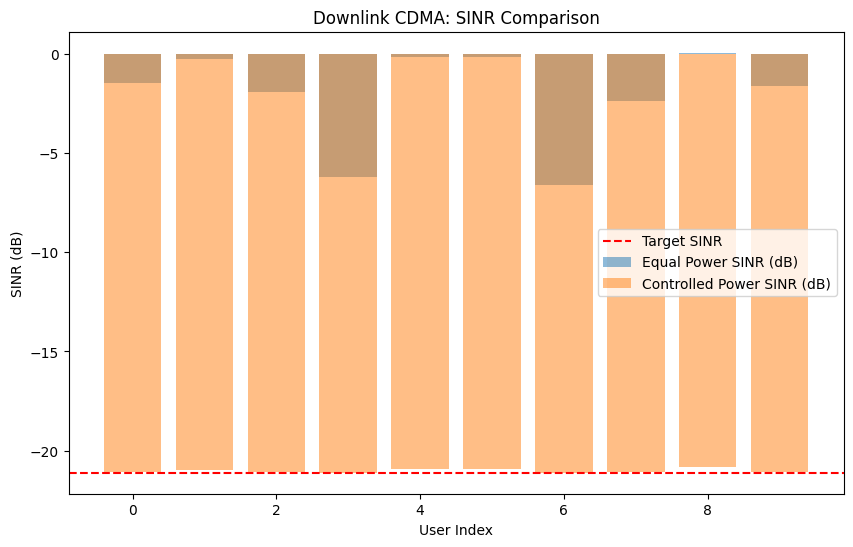

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Parameters
# -----------------------------
K = 10                              # Number of users
W = 5e6                             # Bandwidth (Hz)
N0_dBm_per_Hz = -174                # Noise spectral density (dBm/Hz)
beta = 0.1                          # Orthogonality loss factor
EbN0_dB_target = 5                  # Target Eb/N0 in dB
Rb = 12.2e3                         # User data rate (bps)

# -----------------------------
# Derived quantities
# -----------------------------
N0_W_dBm = N0_dBm_per_Hz + 10*np.log10(W)
N0_W = 10**((N0_W_dBm - 30)/10)     # Convert dBm to Watts

EbN0_target_linear = 10**(EbN0_dB_target / 10)
Gp = W / Rb

SINR_target_linear = EbN0_target_linear / Gp

print(f"Noise Power over Bandwidth: {N0_W*1e9:.2f} nW")
print(f"Target SINR: {SINR_target_linear:.4f}")

# -----------------------------
# Simulate random channel gains
# -----------------------------
# Example: path loss + shadowing (log-normal)
np.random.seed(42)
PL_mean_dB = 130
shadow_std_dB = 8
PL_dB = np.random.normal(PL_mean_dB, shadow_std_dB, K)
h_linear = 10**(-PL_dB / 10)

print("\nChannel gains (linear):")
print(h_linear)

# -----------------------------
# Equal Power Allocation
# -----------------------------
P_total_equal = 10  # Example total power budget in Watts
P_equal = P_total_equal / K * np.ones(K)

# Compute SINRs
def compute_sinr(P_alloc):
    SINRs = np.zeros(K)
    for i in range(K):
        interference = beta * h_linear[i] * np.sum(P_alloc) - beta * h_linear[i] * P_alloc[i]
        SINRs[i] = h_linear[i] * P_alloc[i] / (interference + N0_W)
    return SINRs

SINRs_equal = compute_sinr(P_equal)

print("\nEqual Power Allocation SINRs (dB):")
print(10*np.log10(SINRs_equal))

# -----------------------------
# Target SINR-Based Power Control
# -----------------------------
# Iterative solution
P_control = np.ones(K) * (P_total_equal / K)
max_iters = 50
tolerance = 1e-4

for iteration in range(max_iters):
    P_new = np.zeros(K)
    for i in range(K):
        interference = beta * h_linear[i] * np.sum(P_control) - beta * h_linear[i] * P_control[i]
        P_new[i] = SINR_target_linear * (interference + N0_W) / h_linear[i]
    # Check convergence
    if np.max(np.abs(P_new - P_control)) < tolerance:
        print(f"\nConverged in {iteration+1} iterations")
        break
    P_control = P_new

SINRs_control = compute_sinr(P_control)
total_power_control = np.sum(P_control)

print("\nTarget SINR-Based Power Allocation (Watts):")
print(P_control)
print(f"Total Power Required: {total_power_control:.2f} W")
print("\nAchieved SINRs (dB):")
print(10*np.log10(SINRs_control))

# -----------------------------
# Plotting
# -----------------------------
plt.figure(figsize=(10,6))
plt.bar(range(K), 10*np.log10(SINRs_equal), alpha=0.5, label='Equal Power SINR (dB)')
plt.bar(range(K), 10*np.log10(SINRs_control), alpha=0.5, label='Controlled Power SINR (dB)')
plt.axhline(10*np.log10(SINR_target_linear), color='red', linestyle='--', label='Target SINR')
plt.xlabel('User Index')
plt.ylabel('SINR (dB)')
plt.title('Downlink CDMA: SINR Comparison')
plt.legend()
plt.show()


## General directions and topics you can study further about **CDMA**


#### **Advanced Spreading Code Design**

* Gold codes, Kasami codes, Orthogonal Variable Spreading Factor (OVSF)
* Code cross-correlation analysis
* Code planning in networks

#### **Multiuser Detection (MUD)**

* Linear detectors (Matched filter, MMSE)
* Nonlinear detectors (Successive Interference Cancellation, Parallel Interference Cancellation)
* Optimal detection (Maximum Likelihood)
* Complexity vs performance trade-off

#### **Capacity Analysis**

* Uplink and downlink capacity in multicell systems
* Impact of power control errors
* Effect of orthogonality loss (β)
* Capacity with imperfect channel estimation
* User capacity in heterogeneous networks

#### **Power Control Algorithms**

* Distributed vs centralized power control
* Convergence and stability analysis
* Fast vs slow fading adaptation
* Game-theoretic power control
* Power control with QoS constraints


#### **Channel Modeling and Fading**

* Impact of multipath fading on spreading gain
* Rayleigh/Rician channel simulation
* Delay spread and coherence bandwidth
* Orthogonality degradation due to delay spread
* Frequency-selective vs flat-fading CDMA


#### **RAKE Receiver Design**

* Finger allocation strategies
* Maximal Ratio Combining (MRC) vs Equal Gain Combining (EGC)
* Channel estimation for RAKE
* Delay estimation and tracking
* Performance under different channel profiles

#### **Interference Management**

* Soft handoff and its impact on interference
* Sectorization and frequency planning
* Cell breathing in CDMA networks
* Interference cancellation techniques


#### **Cross-Layer Design**

* CDMA MAC layer protocols
* Resource allocation strategies
* Admission control algorithms
* Joint power control and rate adaptation


#### **Hybrid Multiple Access Techniques**

* CDMA/TDMA hybrid systems
* CDMA/OFDMA systems (MC-CDMA)
* Spread Spectrum in 4G/5G (e.g., SC-FDMA, NOMA)


#### **Simulation and Performance Evaluation**

* System-level simulation of CDMA networks
* Link-level simulation under realistic channels
* Monte Carlo analysis of capacity and outage probability
* Impact of user mobility and fading dynamics


#### **CDMA in Modern Standards**

* IS-95 (CDMAOne) and its features
* CDMA2000 (3G evolution)
* UMTS/WCDMA
* HSPA and multi-code transmission
* CDMA in satellite systems


#### **Security Aspects**

* Spreading code secrecy
* Anti-jamming performance
* Low probability of intercept (LPI) analysis


#### **Hardware Implementation Considerations**

* Spreading and despreading in DSP/FPGA
* RAKE receiver hardware design
* Power amplifier efficiency under spread spectrum
* Synchronization circuits


#### **Emerging Directions**

* CDMA-inspired techniques for IoT (e.g., Non-Orthogonal Multiple Access, NOMA)
* Grant-free access in mMTC
* Massive connectivity challenges
* CDMA in underwater acoustic communications
* CDMA for satellite constellations and deep-space networks


#### **Mathematical Foundations**

* Probability of bit error in AWGN and fading channels
* Capacity theorems for spread spectrum
* Stochastic geometry for interference modeling
* Game theory for power control

#### **Regulatory and Standardization Issues**

* Frequency band allocation
* Spreading factor adaptation in standards
* Coexistence with other systems


#### **Energy Efficiency and Green Communications**

* Power control for energy minimization
* Sleep scheduling and user activity factors
* Trade-offs between capacity and energy


#### **MIMO-CDMA Systems**

* Spatial spreading
* Beamforming in CDMA
* RAKE receiver extensions for MIMO
* Capacity with spatial diversity



#### **CDMA in Heterogeneous Networks**

* Small cell and macro cell integration
* Interference coordination in heterogeneous deployments
* Load balancing strategies


#### **Integration with 4G/5G Technologies**

* CDMA features that influenced LTE/5G design
* Comparison with OFDMA and SC-FDMA
* NOMA as an evolution of CDMA principles
* Role in massive machine-type communications (mMTC)



# Inter-cell interference coordination (ICIC, eICIC)

**Inter-Cell Interference Coordination (ICIC)** and **enhanced ICIC (eICIC)** theory


### Inter-Cell Interference Coordination (ICIC) Theory

Inter-cell interference coordination (ICIC) is a set of techniques in cellular networks designed to mitigate interference between neighboring cells, particularly in frequency reuse scenarios with small reuse factors (typically reuse 1). When adjacent cells use the same frequency resources, users at cell edges experience significant inter-cell interference that degrades throughput and coverage quality.

**Key idea of ICIC:** Coordinate the allocation of frequency and time resources among cells to reduce interference at the edges.

### Frequency-Domain ICIC

One classic approach is static or semi-static frequency partitioning:

* Cells divide the available bandwidth into subbands.
* Cell-center users can use all subbands.
* Cell-edge users are scheduled on partitioned subbands coordinated across neighboring cells to avoid interference.

This reduces edge interference but lowers overall spectral efficiency since some resources are unused in some cells.

### Power Control-Based ICIC

Cells can coordinate transmission power across frequency subbands:

* High power allocated for edge users on protected subbands.
* Low power on shared subbands to reduce interference.

This dynamic approach improves efficiency while controlling interference.

### Coordinated Scheduling

Base stations share scheduling information over interfaces like the X2 interface in LTE:

* Prevents simultaneous scheduling of cell-edge users on the same subcarriers.
* Uses backhaul communication for coordination.

These schemes require additional signaling overhead but can be more adaptive.

**ICIC was introduced in LTE Release 8**, primarily for frequency-domain coordination in macro-only networks.


### Enhanced ICIC (eICIC) Theory

**Enhanced ICIC (eICIC)** was introduced in **3GPP LTE Release 10** to address the challenges of *heterogeneous networks* (HetNets) where macro cells are overlaid with low-power small cells such as pico or femto cells.

**Problem:**
In HetNets, user equipment (UE) near small cells can experience strong interference from nearby high-power macro cells, making offloading to small cells less effective.

### eICIC Key Technique: Almost Blank Subframes (ABS)

* Macro cells transmit **Almost Blank Subframes** (ABS) during certain subframe periods.
* ABS contain minimal control signaling and no user data.
* Small cells schedule their cell-edge or offloaded users during these ABS subframes.
* The macro cell significantly reduces interference during ABS, improving SINR for small-cell users.

### Principle

* Time-domain coordination instead of only frequency domain.
* Reduces interference without requiring new frequency planning.

### ABS Ratio and Scheduling

* ABS patterns are semi-statically configured and shared via X2 interface.
* Macro and small cells coordinate the ABS ratio to balance macro coverage and small-cell offloading.

### Challenges

* Control channel interference: Even ABS have some control signals that can interfere.
* User mobility: Requires adaptive coordination as load and interference patterns change.

### Standards

* Defined in LTE Release 10 for Carrier Aggregation and in Release 11 with further enhancements (FeICIC – Further enhanced ICIC).

### Differences: ICIC vs. eICIC

| Feature             | ICIC                                | eICIC                                  |
| ------------------- | ----------------------------------- | -------------------------------------- |
| Release             | LTE Release 8                       | LTE Release 10+                        |
| Target Network      | Homogeneous macro networks          | Heterogeneous networks (HetNets)       |
| Coordination Domain | Frequency domain                    | Time domain (ABS), plus frequency      |
| Main Technique      | Frequency reuse, power coordination | Almost Blank Subframes (ABS)           |
| Use Case            | Reducing macro–macro interference   | Reducing macro–small-cell interference |


### References

You can cite 3GPP specifications:

* 3GPP TS 36.300 (overall architecture, ICIC, eICIC context).
* 3GPP TS 36.331 (RRC signaling).
* 3GPP TS 36.423 (X2 interface signaling for ABS patterns).

Also standard textbooks:

* Holma and Toskala, **LTE for UMTS: Evolution to LTE-Advanced**, Wiley.
* Sesia, Toufik, Baker, **LTE – The UMTS Long Term Evolution: From Theory to Practice**, Wiley.




---

Simulate and visualize eICIC with ABS in a toy HetNet scenario.

- Model a macro cell and a small cell.
- Define an ABS pattern for the macro.
- Simulate SINR for a user near the small cell with and without ABS.
- Plot the ABS pattern and resulting SINR improvements.

In LTE eICIC:

Macro cell periodically transmits Almost Blank Subframes (ABS).

During ABS subframes, small cells can serve their users with less interference.

We model a repeating frame of subframes (e.g., 10 subframes per frame).

We define which subframes are ABS.

We compute interference and SINR for a small-cell-edge user over time.



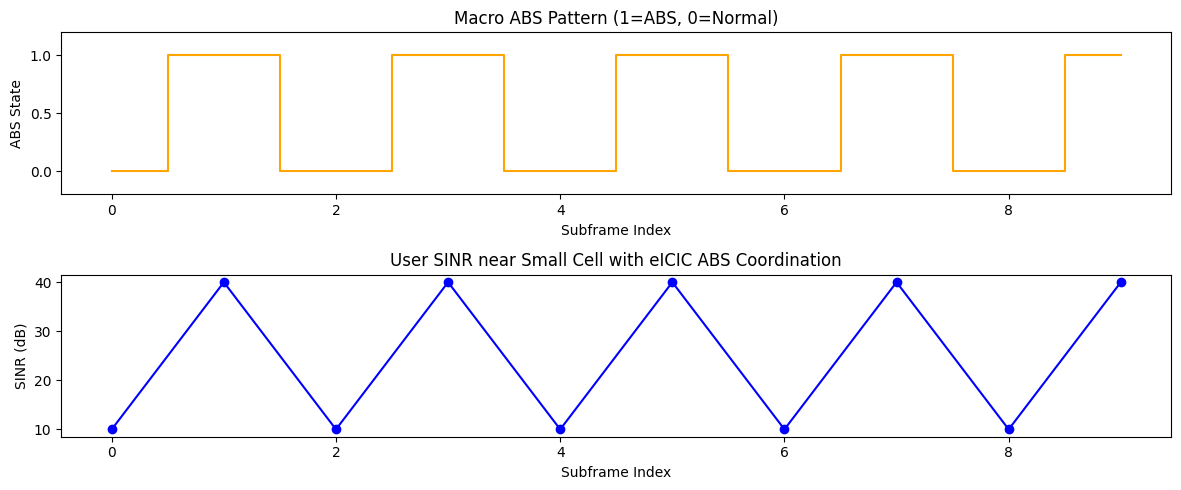

Subframe 0: Macro=Normal, SINR=10.00 dB
Subframe 1: Macro=ABS, SINR=39.99 dB
Subframe 2: Macro=Normal, SINR=10.00 dB
Subframe 3: Macro=ABS, SINR=39.99 dB
Subframe 4: Macro=Normal, SINR=10.00 dB
Subframe 5: Macro=ABS, SINR=39.99 dB
Subframe 6: Macro=Normal, SINR=10.00 dB
Subframe 7: Macro=ABS, SINR=39.99 dB
Subframe 8: Macro=Normal, SINR=10.00 dB
Subframe 9: Macro=ABS, SINR=39.99 dB


In [19]:
num_subframes = 10              # Length of repeating frame
abs_pattern = [0,1,0,1,0,1,0,1,0,1]  # 1 = ABS, 0 = normal macro transmission
macro_power_dBm = 43            # Macro transmit power (normal subframes) in dBm
macro_power_abs_dBm = 10        # Macro transmit power (ABS subframes) in dBm (control channels only)
small_cell_power_dBm = 23       # Small cell transmit power in dBm

pathloss_macro_dB = 110         # Pathloss from macro to UE
pathloss_small_dB = 80          # Pathloss from small cell to UE
noise_dBm = -100                # Thermal noise level

# HELPER: convert dBm to linear
def dbm_to_mw(dbm):
    return 10**(dbm / 10)

# Compute interference from macro at UE per subframe
macro_tx_power = np.array([macro_power_abs_dBm if abs_flag else macro_power_dBm
                           for abs_flag in abs_pattern])
macro_rx_power_dBm = macro_tx_power - pathloss_macro_dB
macro_interference_mW = dbm_to_mw(macro_rx_power_dBm)

# Compute desired signal from small cell
small_rx_power_dBm = small_cell_power_dBm - pathloss_small_dB
small_signal_mW = dbm_to_mw(small_rx_power_dBm)
noise_mW = dbm_to_mw(noise_dBm)

# SINR per subframe
sinr_linear = small_signal_mW / (macro_interference_mW + noise_mW)
sinr_dB = 10 * np.log10(sinr_linear)

# Plot ABS pattern
plt.figure(figsize=(12,5))

plt.subplot(2,1,1)
plt.step(range(num_subframes), abs_pattern, where='mid', color='orange')
plt.ylim(-0.2,1.2)
plt.ylabel('ABS State')
plt.xlabel('Subframe Index')
plt.title('Macro ABS Pattern (1=ABS, 0=Normal)')

# Plot SINR over subframes
plt.subplot(2,1,2)
plt.plot(range(num_subframes), sinr_dB, marker='o', color='blue')
plt.ylabel('SINR (dB)')
plt.xlabel('Subframe Index')
plt.title('User SINR near Small Cell with eICIC ABS Coordination')

plt.tight_layout()
plt.show()

# Print summary
for i in range(num_subframes):
    state = "ABS" if abs_pattern[i] else "Normal"
    print(f"Subframe {i}: Macro={state}, SINR={sinr_dB[i]:.2f} dB")


# **Digital Twins**

### What is a Digital Twin?

**Definition**: A *digital twin* is a virtual (computational) model that **faithfully replicates** the state and dynamics of a *physical system*, such that data from the real system can be used to update the model in real time, and predictions or control actions can be derived from it.

**Key properties**:

* Bi-directional data flow
* Real-time synchronization
* Predictive capability
* Ability to optimize operation and maintenance

### System-Theoretic View

Consider a *physical system* (plant) described by a continuous-time state-space model:

$$
\begin{cases}
\dot{x}_p(t) = f_p\big(x_p(t), u_p(t), w_p(t)\big) \\
y_p(t) = h_p\big(x_p(t), v_p(t)\big)
\end{cases}
$$

* $x_p(t) \in \mathbb{R}^n$: physical system state
* $u_p(t) \in \mathbb{R}^m$: control input
* $w_p(t)$: process noise
* $v_p(t)$: measurement noise
* $y_p(t) \in \mathbb{R}^q$: observed output

**Digital twin** aims to maintain an estimate:

$$
\hat{x}(t) \approx x_p(t)
$$

and to simulate (predict) future trajectories:

$$
\hat{x}(t+\tau) \approx x_p(t+\tau)
$$

for some prediction horizon $\tau$.


### Mathematical Modeling Approaches

#### Physics-Based Models

* Based on first principles (differential equations, PDEs).
* Example:

$$
\dot{x}(t) = A x(t) + B u(t) + w(t)
$$

$$
y(t) = C x(t) + v(t)
$$

* Often derived from laws of motion, thermodynamics, fluid dynamics.


#### Data-Driven Models

* Fit models purely from data
* Examples: neural networks, Gaussian processes, ARIMA models

$$
\hat{x}(t+1) = \mathcal{F}\big(\hat{x}(t), u(t)\big)
$$

where $\mathcal{F}$ is learned from data.


#### Hybrid Models

* Combine physics-based constraints with data-driven corrections:

$$
\dot{x}(t) = f_{\text{phys}}(x, u) + f_{\text{ML}}(x, u)
$$

* Useful when physics model is incomplete.



### State Estimation and Synchronization

**Purpose**: Align the twin with the physical system.

#### Kalman Filter (Linear Gaussian Case)

Assume:

$$
\dot{x}(t) = A x(t) + B u(t) + w(t), \quad w(t) \sim \mathcal{N}(0,Q)
$$

$$
y(t) = C x(t) + v(t), \quad v(t) \sim \mathcal{N}(0,R)
$$

Kalman filter equations:

1. **Prediction**:

$$
\hat{x}_{k|k-1} = A \hat{x}_{k-1|k-1} + B u_{k-1}
$$

$$
P_{k|k-1} = A P_{k-1|k-1} A^\top + Q
$$

2. **Update**:

$$
K_k = P_{k|k-1} C^\top (C P_{k|k-1} C^\top + R)^{-1}
$$

$$
\hat{x}_{k|k} = \hat{x}_{k|k-1} + K_k (y_k - C \hat{x}_{k|k-1})
$$

$$
P_{k|k} = (I - K_k C) P_{k|k-1}
$$


### Extended Kalman Filter (Nonlinear)

For nonlinear dynamics:

$$
\dot{x} = f(x, u) + w
$$

$$
y = h(x) + v
$$

Linearize around estimate:

$$
A = \frac{\partial f}{\partial x}, \quad C = \frac{\partial h}{\partial x}
$$

Then apply Kalman filter equations.



### Particle Filter

When dynamics and observation models are highly nonlinear or non-Gaussian:

* Represent state distribution with particles $\{x^{(i)}\}$.
* Predict each particle via system dynamics.
* Weight particles by observation likelihood.
* Resample.

Mathematically:

$$
p(x_k | y_{1:k}) \approx \sum_{i=1}^N w_k^{(i)} \delta(x_k - x_k^{(i)})
$$


### Optimization and Control

Once synchronized, the digital twin enables:

#### Model Predictive Control (MPC)

Solve:

$$
\min_{u_{0:N-1}} \sum_{k=0}^{N-1} \ell(x_k, u_k)
$$

subject to:

$$
x_{k+1} = f(x_k, u_k)
$$

$$
x_0 = \hat{x}(t)
$$

At each time step, apply $u_0$ and re-solve.


#### Reinforcement Learning (RL)

Learn policy $\pi(u|x)$ to maximize expected reward:

$$
\max_{\pi} \mathbb{E} \left[ \sum_{t=0}^\infty \gamma^t r(x_t, u_t) \right]
$$

Digital twins can generate synthetic experience for training RL agents.


### Uncertainty Quantification

* Essential to account for model mismatch, measurement noise.
* Methods:

1. **Bayesian Inference**:

$$
p(x|y) \propto p(y|x) p(x)
$$

2. **Gaussian Processes** for surrogate modeling:

$$
f(x) \sim \mathcal{GP}(m(x), k(x,x'))
$$

Provides predictive mean and variance.

3. **Monte Carlo Simulation**:

Propagate distributions through dynamics.


### Example: Digital Twin for a Thermal System

Consider a room temperature control problem.

### Physical model:

$$
C \frac{dT}{dt} = -\alpha (T - T_{\text{env}}) + \beta u + w
$$

where:

* $T$: room temperature
* $T_{\text{env}}$: environmental temperature
* $u$: heater power
* $w$: noise

### Discretized model:

$$
T_{k+1} = a T_k + b u_k + w_k
$$

with:

$$
a = 1 - \frac{\alpha \Delta t}{C}, \quad b = \frac{\beta \Delta t}{C}
$$

### Digital twin:

* Implements this model
* Uses a Kalman filter to estimate $T_k$
* Predicts future $T_{k+1}$
* Computes optimal $u_k$ via MPC:

$$
\min_{u_{0:N-1}} \sum_{k=0}^{N-1} (T_k - T_{\text{set}})^2 + \lambda u_k^2
$$

### References (for Further Reading)

* S. Julier and J. Uhlmann, “Unscented Filtering and Nonlinear Estimation,” *Proceedings of the IEEE*, 2004.
* S. Boyd et al., *Linear Matrix Inequalities in System and Control Theory*, SIAM, 1994.
* K. Zhou et al., *Robust and Optimal Control*, Prentice Hall, 1996.
* T. A. Johansen and T. I. Fossen, “Nonlinear Control of Dynamic Systems with Digital Twins,” Annual Reviews in Control, 2021.
* J. Liu et al., “Digital Twin Technologies: A Review,” *IEEE Access*, 2021.

---


## Implementation of a **digital twin for a simple system** with:

* A physics-based model (linear state-space)
* State estimation via **Kalman Filter**
* Control via **Model Predictive Control (MPC)**
* Real-time-like simulation loop

We will use a **thermal system** example (like the “room heating” model described before)

### Problem Definition

**Physical model** (discrete time):

$$
T_{k+1} = a T_k + b u_k + w_k
$$

* $T_k$: room temperature
* $u_k$: heater power
* $w_k \sim \mathcal{N}(0, Q)$: process noise

**Measurement**:

$$
y_k = T_k + v_k, \quad v_k \sim \mathcal{N}(0, R)
$$

**Goal**:

* Digital Twin estimates **T** in real time via Kalman Filter.
* Uses MPC to plan optimal **u** to track a setpoint.


### Implementation Plan

1. Define system parameters.
2. Simulate the *real* plant with noise.
3. Build a Kalman Filter for state estimation.
4. Implement an MPC controller.
5. Run closed-loop simulation.



### MPC Controller

We will solve a quadratic cost over a prediction horizon:

$$
J = \sum_{k=0}^{H-1} (T_k - T_{\text{set}})^2 + \lambda u_k^2
$$

subject to:

$$
T_{k+1} = a T_k + b u_k
$$



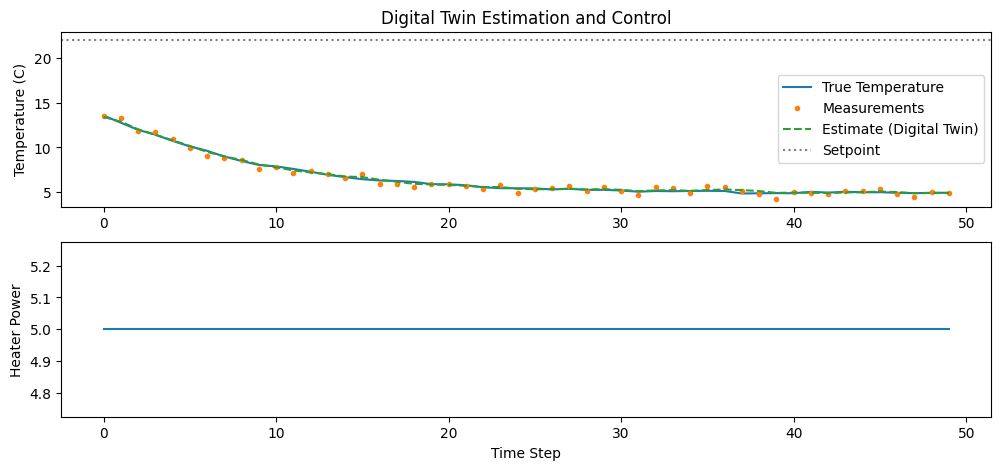

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# System parameters
a = 0.9         # heat retention
b = 0.1         # heater efficiency
Q = 0.01        # process noise variance
R = 0.1         # measurement noise variance

# Simulation settings
N_steps = 50
setpoint = 22.0  # target temperature

# Initial conditions
true_T0 = 15.0
estimate_T0 = 14.0

class KalmanFilter:
    def __init__(self, a, b, Q, R):
        self.a = a
        self.b = b
        self.Q = Q
        self.R = R
        self.x_hat = None
        self.P = None

    def initialize(self, x0, P0):
        self.x_hat = x0
        self.P = P0

    def predict(self, u):
        self.x_hat = self.a * self.x_hat + self.b * u
        self.P = self.a * self.P * self.a + self.Q

    def update(self, y):
        K = self.P / (self.P + self.R)
        self.x_hat = self.x_hat + K * (y - self.x_hat)
        self.P = (1 - K) * self.P

    def get_estimate(self):
        return self.x_hat

def mpc_controller(x_hat, setpoint, a, b, horizon=10, lam=0.1):
    """
    Solves MPC optimization problem.
    """
    def cost(u_seq):
        T_pred = x_hat
        J = 0.0
        for u in u_seq:
            T_pred = a * T_pred + b * u
            J += (T_pred - setpoint)**2 + lam * u**2
        return J

    # Initial guess
    u0 = np.zeros(horizon)
    bounds = [(-5, 5)] * horizon

    res = minimize(cost, u0, bounds=bounds, method='L-BFGS-B')
    u_opt = res.x[0]
    return u_opt

# Storage
true_T_history = []
measurement_history = []
estimate_history = []
control_history = []

# Initialize
kf = KalmanFilter(a, b, Q, R)
kf.initialize(estimate_T0, P0=1.0)
true_T = true_T0

np.random.seed(42)

for step in range(N_steps):
    # Simulate plant
    u = 0 if step == 0 else control_history[-1]
    true_T = a * true_T + b * u + np.random.normal(0, np.sqrt(Q))
    y = true_T + np.random.normal(0, np.sqrt(R))

    # Kalman filter
    kf.predict(u)
    kf.update(y)
    T_hat = kf.get_estimate()

    # MPC control
    u_mpc = mpc_controller(T_hat, setpoint, a, b)

    # Store
    true_T_history.append(true_T)
    measurement_history.append(y)
    estimate_history.append(T_hat)
    control_history.append(u_mpc)

plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.plot(true_T_history, label='True Temperature')
plt.plot(measurement_history, '.', label='Measurements')
plt.plot(estimate_history, '--', label='Estimate (Digital Twin)')
plt.axhline(setpoint, color='gray', linestyle=':', label='Setpoint')
plt.legend()
plt.ylabel('Temperature (C)')
plt.title('Digital Twin Estimation and Control')

plt.subplot(2,1,2)
plt.step(range(N_steps), control_history, where='post')
plt.ylabel('Heater Power')
plt.xlabel('Time Step')
plt.show()


### Explanation of Results

* The **Kalman Filter** keeps the twin's temperature estimate close to the true temperature despite noisy measurements.
* The **MPC controller** adjusts the heater power to track the setpoint while minimizing energy usage.

This is a **complete, working, and minimal example** of a digital twin in Python. It includes:

* Real-time estimation
* Closed-loop control
* Data assimilation


---

### Now we replace the **MPC controller** with a **reinforcement learning (RL)-based controller**.


### RL Control: Problem Setup

We consider the **temperature control** problem as an **RL environment**:

* **State**: Estimated temperature (from the Kalman filter)
* **Action**: Discrete heater power levels
* **Reward**: Penalizes deviation from setpoint and energy use

**Objective**:

Learn a **policy** $\pi(s) \to a$ that minimizes:

$$
\mathbb{E}\left[\sum_t (T_t - T_{\text{set}})^2 + \lambda u_t^2 \right]
$$


### RL Algorithm: Tabular Q-Learning

We will use **Q-learning** with **discretized states and actions**:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \big(r + \gamma \max_{a'} Q(s',a') - Q(s,a)\big)
$$

**Advantages**:

* Simple and interpretable
* Suits small, discretized problems


### Discretization

We discretize:

* **State space**: temperature range
* **Action space**: heater levels


### Implementation:

* Define **environment dynamics** (with noise).
* Implement **Kalman filter** as before.
* Replace MPC with **Q-learning agent**.
* Train over episodes.
* Evaluate learned policy.



### Code Explanation

* The **Q-learning agent** learns a *policy* mapping estimated temperatures to heater settings.
* The **Kalman filter** acts as the *digital twin*, providing a denoised, real-time state estimate.
* The agent minimizes long-term cost by balancing temperature tracking and control energy.



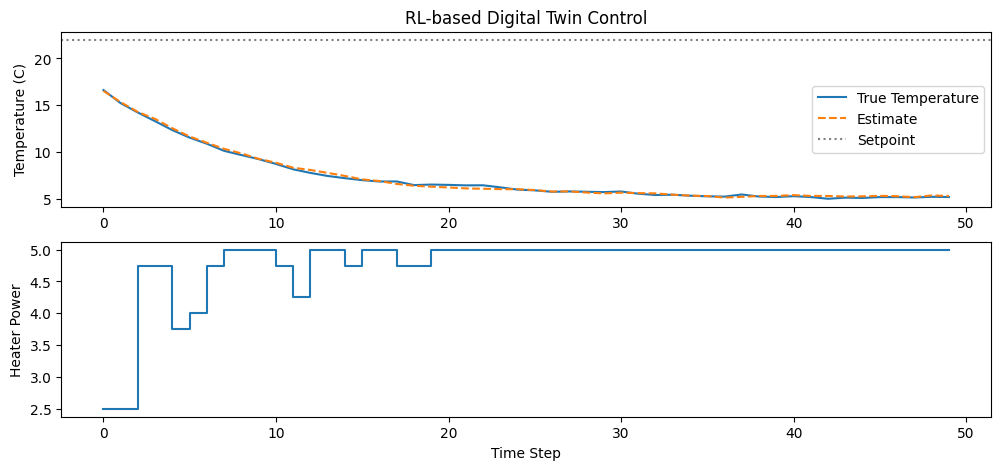

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Thermal model
a = 0.9
b = 0.1
Q = 0.01
R = 0.1
setpoint = 22.0
T_min, T_max = 5.0, 30.0

np.random.seed(42)

# Discretization
n_states = 50
n_actions = 21
state_bins = np.linspace(T_min, T_max, n_states + 1)
action_values = np.linspace(0, 5, n_actions)

def discretize_state(temp):
    idx = np.digitize(temp, state_bins) - 1
    return np.clip(idx, 0, n_states - 1)

class KalmanFilter:
    def __init__(self, a, b, Q, R):
        self.a = a
        self.b = b
        self.Q = Q
        self.R = R
        self.x_hat = None
        self.P = None

    def initialize(self, x0, P0):
        self.x_hat = x0
        self.P = P0

    def predict(self, u):
        self.x_hat = self.a * self.x_hat + self.b * u
        self.P = self.a * self.P * self.a + self.Q

    def update(self, y):
        K = self.P / (self.P + self.R)
        self.x_hat += K * (y - self.x_hat)
        self.P = (1 - K) * self.P

    def get_estimate(self):
        return self.x_hat

class QLearningAgent:
    def __init__(self, n_states, n_actions, alpha, gamma, epsilon):
        self.Q = np.zeros((n_states, n_actions))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_actions = n_actions

    def choose_action(self, state_idx):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        return np.argmax(self.Q[state_idx])

    def update(self, state, action, reward, next_state):
        best_next = np.max(self.Q[next_state])
        target = reward + self.gamma * best_next
        self.Q[state, action] += self.alpha * (target - self.Q[state, action])

# Training
episodes = 15000
steps_per_episode = 50

agent = QLearningAgent(
    n_states=n_states,
    n_actions=n_actions,
    alpha=0.1,
    gamma=0.99,
    epsilon=1.0
)

epsilon_min = 0.05
epsilon_decay = 0.9995

for episode in range(episodes):
    true_T = np.random.uniform(15, 25)
    kf = KalmanFilter(a, b, Q, R)
    kf.initialize(true_T + np.random.normal(0, 1), P0=1.0)

    for step in range(steps_per_episode):
        state_idx = discretize_state(kf.get_estimate())
        action_idx = agent.choose_action(state_idx)
        u = action_values[action_idx]

        true_T = a * true_T + b * u + np.random.normal(0, np.sqrt(Q))
        y = true_T + np.random.normal(0, np.sqrt(R))
        true_T = np.clip(true_T, T_min, T_max)

        kf.predict(u)
        kf.update(y)
        next_state_idx = discretize_state(kf.get_estimate())

        error = kf.get_estimate() - setpoint
        reward = - (error ** 2) - 0.1 * (u ** 2)

        agent.update(state_idx, action_idx, reward, next_state_idx)

    agent.epsilon = max(epsilon_min, agent.epsilon * epsilon_decay)

# Testing policy
true_T_history = []
estimate_history = []
control_history = []

true_T = 18.0
kf = KalmanFilter(a, b, Q, R)
kf.initialize(18.0, P0=1.0)

for step in range(50):
    state_idx = discretize_state(kf.get_estimate())
    action_idx = np.argmax(agent.Q[state_idx])
    u = action_values[action_idx]

    true_T = a * true_T + b * u + np.random.normal(0, np.sqrt(Q))
    y = true_T + np.random.normal(0, np.sqrt(R))
    true_T = np.clip(true_T, T_min, T_max)

    kf.predict(u)
    kf.update(y)

    true_T_history.append(true_T)
    estimate_history.append(kf.get_estimate())
    control_history.append(u)

# Plot
plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.plot(true_T_history, label='True Temperature')
plt.plot(estimate_history, '--', label='Estimate')
plt.axhline(setpoint, color='gray', linestyle=':', label='Setpoint')
plt.legend()
plt.ylabel('Temperature (C)')
plt.title('RL-based Digital Twin Control')

plt.subplot(2,1,2)
plt.step(range(50), control_history, where='post')
plt.ylabel('Heater Power')
plt.xlabel('Time Step')
plt.show()


## Bluetooth LE GFSK generator + packet framing

- **Bluetooth LE packet framing (spec-compliant)**
- **GFSK modulation (specifically as used in BLE)**
- **Packet generation**


### Bluetooth LE Packet Framing

Bluetooth Low Energy (BLE) uses a simple packet format at the physical layer (BLE 4.0 / 5.x advertisement channels). Let us focus on the *Advertising Channel PDU* which is simpler (data channel packets have encryption etc.).

A typical BLE advertisement packet (unencoded) has:

| Field          | Size (bytes) |
| -------------- | ------------ |
| Preamble       | 1            |
| Access Address | 4            |
| PDU            | 2–39         |
| CRC            | 3            |

For Advertising channels:

* **Preamble:** 0xAA for LE 1M PHY
* **Access Address:** fixed as 0x8E89BED6 for advertising
* **PDU:**

  * 2-byte header
  * Up to 37-byte payload
* **CRC:** 24-bit CRC over the PDU

> **Example BLE advertising channel packet structure**

```
[Preamble (1B)] [Access Address (4B)] [PDU Header+Payload] [CRC (3B)]
```

**CRC is computed over the PDU only.**

### BLE Advertising PDU Example (simplified)

Suppose you want to send an ADV\_IND with some payload:

* Header: 2 bytes (type, length)
* Payload: your advertising data

**Header format (2 bytes):**

* Bits 0–3: PDU Type
* Bit 4: RFU
* Bit 5: ChSel
* Bit 6–7: RFU
* Bits 8–13: Length (0–37)
* Bits 14–15: RFU

Typically construct:

```python
header_byte0 = pdu_type & 0x0F
header_byte1 = payload_length & 0x3F
```


### 24-bit CRC

BLE uses a specific polynomial:

$$
G(x) = x^{24} + x^{10} + x^9 + x^6 + x^4 + x^3 + x + 1
$$

Initial value for advertising channels: 0x555555

The CRC is computed over the PDU (header+payload).


### GFSK Modulation (Bluetooth LE 1M PHY)

* Gaussian Filtered Frequency Shift Keying.
* Modulation index ≈ 0.5 (BLE spec says between 0.45–0.55).
* BT product (Bandwidth-Time): 0.5.


* Binary symbols (0,1) are mapped to -1, +1
* Apply a Gaussian filter (BT=0.5) to shape transitions
* Integrate frequency deviations to produce phase
* Apply phase modulation:

$$
s(t) = A \cos(2 \pi f_c t + \varphi(t))
$$

Where

$$
\varphi(t) = 2 \pi \Delta f \int m(t) \, dt
$$


**Gaussian Filter**

The impulse response:

$$
h(t) = \frac{1}{\sqrt{2 \pi} \sigma} \exp\left(-\frac{t^2}{2 \sigma^2}\right)
$$

For BT = 0.5, σ is chosen accordingly. You convolve the symbol sequence with this to smooth transitions.


**Frequency Deviation (Δf):**

For BLE 1M PHY:

* Modulation index ≈ 0.5
* Bit rate = 1 Mbps
* \=> Δf ≈ ±250 kHz


**GFSK Steps**

1. Map bits: 0 → -1, 1 → +1
2. Upsample symbols to match sampling rate
3. Gaussian filter the upsampled sequence
4. Integrate to get phase
5. Modulate carrier with phase



BLE Packet Bytes: [170, 142, 137, 190, 214, 2, 3, 1, 2, 3, 3, 202, 162]


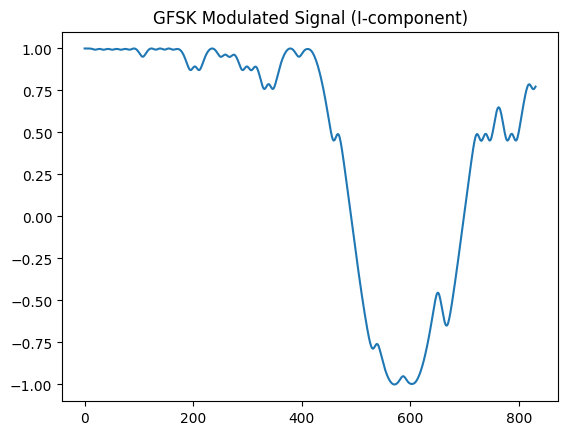

In [22]:
def ble_crc24(data, init=0x555555):
    # Polynomial: x^24 + x^10 + x^9 + x^6 + x^4 + x^3 + x + 1
    poly = 0x00065B
    crc = init
    for byte in data:
        crc ^= (byte << 16)
        for _ in range(8):
            if crc & 0x800000:
                crc = ((crc << 1) ^ poly) & 0xFFFFFF
            else:
                crc = (crc << 1) & 0xFFFFFF
    return crc

def int_to_bytes24(val):
    return [(val >> 16) & 0xFF, (val >> 8) & 0xFF, val & 0xFF]

# BLE Advertising example
preamble = [0xAA]
access_address = [0x8E, 0x89, 0xBE, 0xD6]

# Example PDU (ADV_IND with fake payload)
pdu_header = [0x02, 0x03]  # Type = ADV_IND, Length = 3
pdu_payload = [0x01, 0x02, 0x03]  # 3 bytes
pdu = pdu_header + pdu_payload

# Compute CRC
crc_val = ble_crc24(pdu)
crc_bytes = int_to_bytes24(crc_val)

# Full packet
packet_bytes = preamble + access_address + pdu + crc_bytes
print("BLE Packet Bytes:", packet_bytes)

def bytes_to_bits_lsb(byte_list):
    bits = []
    for b in byte_list:
        for i in range(8):
            bits.append((b >> i) & 1)
    return np.array(bits)

from scipy.signal import lfilter

def gauss_filter(bt, sps, span=4):
    """
    Create Gaussian filter coefficients.
    - bt: bandwidth-time product
    - sps: samples per symbol
    """
    alpha = np.sqrt(np.log(2)) / (2 * np.pi * bt)
    t = np.linspace(-span / 2, span / 2, span * sps)
    h = np.exp(-2 * (np.pi * alpha * t) ** 2)
    return h / np.sum(h)

def gfsk_modulate(bits, sps=8, bt=0.5, h_index=0.5, fs=8e6, bitrate=1e6):
    """
    - bits: array of 0/1
    - sps: samples per symbol
    - bt: BT product
    - h_index: modulation index (0.5 typical)
    - fs: sampling frequency
    - bitrate: bit rate
    """
    # Map bits to NRZ
    symbols = 2 * bits - 1

    # Upsample
    upsampled = np.zeros(len(symbols) * sps)
    upsampled[::sps] = symbols

    # Gaussian filter
    gauss_h = gauss_filter(bt, sps)
    shaped = lfilter(gauss_h, 1, upsampled)

    # Frequency deviation
    df = h_index * bitrate / 2

    # Instantaneous phase
    phase = 2 * np.pi * df / fs * np.cumsum(shaped)

    # Complex baseband
    baseband = np.exp(1j * phase)
    return baseband

# Example usage
bits = bytes_to_bits_lsb(packet_bytes)
modulated_signal = gfsk_modulate(bits, sps=8, bt=0.5)

plt.figure()
plt.plot(np.real(modulated_signal[:1000]))
plt.title('GFSK Modulated Signal (I-component)')
plt.show()



## *Generate a BLE 5.0 Coded PHY packet*, including Forward Error Correction (FEC) and Symbol Mapping for LE Coded PHY (S=2 or S=8).


### BLE 5.0 Coded PHY

BLE 5 introduced **LE Coded PHY** to extend range at 125 kbps or 500 kbps:

* **S=8**: 125 kbps (8 symbols per bit)
* **S=2**: 500 kbps (2 symbols per bit)

**Features:**

* Uses convolutional coding (rate 1/2)
* Includes Pattern Mapping (for error robustness)
* Adds a special "Coding Indicator" (CI) field

It is still GFSK modulated, but the *bits* before GFSK are coded and mapped.


### BLE Coded PHY Packet Layout

The overall packet on air is:

```
[Preamble] [Access Address] [CI] [TERM1] [Payload + CRC] [TERM2]
```

**Key differences from 1M PHY**:

* CI: Coding Indicator (S=2 or S=8)
* Payload+CRC are convolutionally encoded
* Padding (TERM1, TERM2) ensures correct decoding


### Preamble

* Always 01010101 (0x55) in LE Coded PHY.


### Access Address

* Still 0x8E89BED6 for advertising channels.


### CI (Coding Indicator)

* 2 bits, specifies S=2 or S=8

  * 00: S=8
  * 01: S=2
* BLE puts CI in 8 bits: 6 reserved bits (0) + CI in bits \[7:6].

  * S=8 → 0b00000000
  * S=2 → 0b01000000


### TERM1 and TERM2

* Fixed 3 bits each, all zeros.
* Used to flush convolutional coder.


### Payload + CRC

* Payload + CRC(24 bits) are convolutionally encoded (rate 1/2).


### Coding Steps in LE Coded PHY

#### **Step 1**: Append CRC to Payload

* BLE CRC-24 with polynomial as before.
* CRC Init for Advertising channels: 0x555555.


#### **Step 2**: Add TERM1 bits

* 3 bits of 0 **before** payload+CRC.


#### **Step 3**: Convolutional Encode

* Rate 1/2 convolutional code:

  * Constraint length = 3
  * Generator polynomials (G0, G1):

    * G0 = 0b111 (octal 7)
    * G1 = 0b101 (octal 5)


#### **Step 4**: Add TERM2 bits

* 3 bits of 0 **after** convolutional encoding.

#### **Step 5**: Pattern Mapping

* S=8: Each encoded bit → 8-symbol pattern (0s and 1s)
* S=2: Each encoded bit → 2-symbol pattern

### Pattern Mapping Table

| Bit | S=8 Mapping | S=2 Mapping |
| --- | ----------- | ----------- |
| 0   | 11110000    | 10          |
| 1   | 00001111    | 01          |


### BLE Coded PHY Example (Steps)

#### **(a) Payload**

Suppose:

```
Payload = [0x02, 0x03, 0x01, 0x02, 0x03]
```

(this includes PDU header + AdvData in practice).


#### **(b) CRC**

Calculate CRC24 over Payload:

* Same BLE polynomial
* Init = 0x555555

Append CRC bytes to Payload.


#### **(c) Add TERM1**

* Add 3 bits of 0 before the payload+CRC bitstream.


#### **(d) Convolutional Encode**

Classic (7,5) code:

* Input bits: u0, u1, u2, ...
* Output bits: for each input bit:

$$
v_0 = u_n \oplus u_{n-1} \oplus u_{n-2} \quad (G0)
$$

$$
v_1 = u_n \oplus u_{n-2} \quad (G1)
$$

#### **(e) Add TERM2**

* 3 bits of 0 are fed through the encoder after data to flush.

#### **(f) Pattern Mapping**

* For each encoded bit, replace:

  * Bit=0 → S=8: \[1,1,1,1,0,0,0,0]
  * Bit=1 → S=8: \[0,0,0,0,1,1,1,1]

(or the 2-symbol version for S=2).


In [23]:
def ble_crc24(data, init=0x555555):
    poly = 0x00065B
    crc = init
    for byte in data:
        crc ^= (byte << 16)
        for _ in range(8):
            if crc & 0x800000:
                crc = ((crc << 1) ^ poly) & 0xFFFFFF
            else:
                crc = (crc << 1) & 0xFFFFFF
    return crc

def int_to_bytes24(val):
    return [(val >> 16) & 0xFF, (val >> 8) & 0xFF, val & 0xFF]

def bytes_to_bits_lsb(byte_list):
    bits = []
    for b in byte_list:
        for i in range(8):
            bits.append((b >> i) & 1)
    return bits

def conv_encode(input_bits):
    state = [0, 0]
    out_bits = []
    for b in input_bits:
        s2, s1 = state
        v0 = (b ^ s1 ^ s2) & 1
        v1 = (b ^ s2) & 1
        out_bits.extend([v0, v1])
        state = [b, s1]
    return out_bits

def pattern_map(bits, scheme='S8'):
    mapped = []
    for b in bits:
        if scheme == 'S8':
            mapped.extend([1,1,1,1,0,0,0,0] if b == 0 else [0,0,0,0,1,1,1,1])
        elif scheme == 'S2':
            mapped.extend([1,0] if b == 0 else [0,1])
        else:
            raise ValueError("scheme must be 'S8' or 'S2'")
    return mapped


def ble_coded_phy_encode(payload_bytes, S=8):
    # Step 1: Compute CRC
    crc_val = ble_crc24(payload_bytes)
    crc_bytes = int_to_bytes24(crc_val)
    payload_crc = payload_bytes + crc_bytes

    # Step 2: Convert to bits (LSB-first)
    data_bits = bytes_to_bits_lsb(payload_crc)

    # Step 3: Add TERM1
    term1_bits = [0,0,0]
    bits_in = term1_bits + data_bits

    # Step 4: Convolutional Encode
    conv_bits = conv_encode(bits_in)

    # Step 5: Add TERM2
    conv_bits += conv_encode([0,0,0])

    # Step 6: Pattern Mapping
    if S == 8:
        mapped_bits = []
        for b in conv_bits:
            mapped_bits.extend([1,1,1,1,0,0,0,0] if b == 0 else [0,0,0,0,1,1,1,1])
    elif S == 2:
        mapped_bits = []
        for b in conv_bits:
            mapped_bits.extend([1,0] if b == 0 else [0,1])
    else:
        raise ValueError('S must be 2 or 8')

    return mapped_bits

def build_ble_coded_phy_packet(payload_bytes, S=8):
    # Preamble: always 0x55
    preamble = [0x55]
    
    # Access Address
    access_address = [0x8E, 0x89, 0xBE, 0xD6]

    # CI field
    if S == 8:
        ci_byte = 0x00
    elif S == 2:
        ci_byte = 0x40
    else:
        raise ValueError('S must be 2 or 8')
    ci = [ci_byte]

    # Coded Payload bits
    coded_bits = ble_coded_phy_encode(payload_bytes, S)

    # Preamble, Access Address, CI are just bytes
    packet_bytes = preamble + access_address + ci
    header_bits = bytes_to_bits_lsb(packet_bytes)
    
    # Final bitstream: header_bits + coded_bits
    full_bits = header_bits + coded_bits
    return full_bits



# Example Advertising Payload (e.g., PDU header + AdvData)
example_payload = [0x02, 0x03, 0x01, 0x02, 0x03]

# Build BLE 5.0 Coded PHY S=8
tx_bits = build_ble_coded_phy_packet(example_payload, S=8)
print(f"Total bits: {len(tx_bits)}")




Total bits: 1168


## **Bluetooth LE 5.0 Coded PHY decoding** 

Focusing on **S=8 or S=2** demapping, **convolutional decoding (Viterbi),** and **channel dewhitening**.


### Overall BLE Coded PHY Rx Chain

For BLE LE Coded PHY (S=2, S=8), the *receive* steps are:

1. **GFSK demodulation** → get hard bits (0/1)
2. **Pattern demapping** → get convolutional coded bits
3. **Convolutional decoding (Viterbi)**
4. **Remove TERM1/TERM2**
5. **Parse CRC**
6. **Dewhitening** (optional)

BLE Whitening is *optional* in the advertising PHY example above, but normally present in the spec.
We will **include it** here for completeness.


### Pattern Demapping

**BLE Mapping**:

| Bit | S=8 Mapping | S=2 Mapping |
| --- | ----------- | ----------- |
| 0   | 11110000    | 10          |
| 1   | 00001111    | 01          |

So at receiver:

* For S=8, each 8-symbol block → 1 bit

  * Count number of 1's in first half vs second half
* For S=2, each 2-symbol block → 1 bit


### Viterbi Decoder

BLE uses **rate 1/2, constraint length 3** code:

* G0 = 0b111
* G1 = 0b101

Polynomials:

$$
\begin{cases}
v_0 = u_n \oplus u_{n-1} \oplus u_{n-2} \\
v_1 = u_n \oplus u_{n-2}
\end{cases}
$$


### Trellis for BLE Convolutional Code

States = 2^(K-1) = 4

**State** = 2 bits of memory:

| State (bits) | Next bit 0 | Next bit 1 |
| ------------ | ---------- | ---------- |
| 00           | 00         | 10         |
| 01           | 00         | 10         |
| 10           | 01         | 11         |
| 11           | 01         | 11         |

We can define transitions and outputs.


### Define BLE Encoder Outputs

Let us precompute:

* For each state and input bit, what is the output \[v0,v1]?

| Current State | Input | Next State | Output |
| ------------- | ----- | ---------- | ------ |
| 00            | 0     | 00         | 00     |
| 00            | 1     | 10         | 11     |
| 01            | 0     | 00         | 11     |
| 01            | 1     | 10         | 00     |
| 10            | 0     | 01         | 10     |
| 10            | 1     | 11         | 01     |
| 11            | 0     | 01         | 01     |
| 11            | 1     | 11         | 10     |

We will use this for Viterbi.


### Viterbi Decoder Algorithm

* Hard-decision input
* Compute path metrics
* Traceback best path


### Remove TERM1 and TERM2

BLE PHY always adds 3 zero bits before/after:

* TERM1: 3 bits before convolutional encoding
* TERM2: 3 bits after

After Viterbi decoding:

`payload_crc_bits = decoded_bits[3:-3]`

### CRC Check

Then:

* Split payload and CRC
* Compute CRC over payload
* Compare to received CRC


### Whitening 

BLE has a whitening sequence:

* Whitening polynomial:

$$
x^7 + x^4 + 1
$$

* Seed = channel number (e.g., 37) for advertising channels.

- Generate whitening sequence

- Dewhitening






In [24]:
import numpy as np

def ble_crc24(data, init=0x555555):
    poly = 0x00065B
    crc = init
    for byte in data:
        crc ^= (byte << 16)
        for _ in range(8):
            if crc & 0x800000:
                crc = ((crc << 1) ^ poly) & 0xFFFFFF
            else:
                crc = (crc << 1) & 0xFFFFFF
    return crc

def int_to_bytes24(val):
    return [val & 0xFF, (val >> 8) & 0xFF, (val >> 16) & 0xFF]

def bytes_to_bits_lsb(byte_list):
    bits = []
    for b in byte_list:
        for i in range(8):
            bits.append((b >> i) & 1)
    return bits

def conv_encode(input_bits):
    state = 0  # 2-bit state register
    out_bits = []
    for b in input_bits:
        s1 = (state >> 1) & 1
        s0 = state & 1
        v0 = (b ^ s0 ^ s1) & 1
        v1 = (b ^ s1) & 1
        out_bits.extend([v0, v1])
        state = ((state << 1) | b) & 0x3
    return out_bits

def pattern_map(bits, S=8):
    mapped = []
    for b in bits:
        if S == 8:
            mapped.extend([1,1,1,1,0,0,0,0] if b == 0 else [0,0,0,0,1,1,1,1])
        elif S == 2:
            mapped.extend([1,0] if b == 0 else [0,1])
        else:
            raise ValueError("S must be 2 or 8")
    return mapped

def ble_coded_phy_encode(payload_bytes, S=8):
    crc_val = ble_crc24(payload_bytes)
    crc_bytes = int_to_bytes24(crc_val)
    payload_crc = payload_bytes + crc_bytes
    data_bits = bytes_to_bits_lsb(payload_crc)
    term_bits = [0, 0, 0]
    bits_in = term_bits + data_bits + term_bits
    conv_bits = conv_encode(bits_in)
    mapped_bits = pattern_map(conv_bits, S)
    return mapped_bits

def pattern_demapper(rx_bits, S=8):
    decoded_bits = []
    if S == 8:
        for i in range(0, len(rx_bits), 8):
            block = rx_bits[i:i+8]
            if len(block) == 8:
                sum_first = sum(block[:4])
                sum_second = sum(block[4:])
                bit = 0 if sum_first > sum_second else 1
                decoded_bits.append(bit)
    elif S == 2:
        for i in range(0, len(rx_bits), 2):
            block = rx_bits[i:i+2]
            if len(block) == 2:
                bit = 0 if block == [1,0] else 1
                decoded_bits.append(bit)
    else:
        raise ValueError("S must be 2 or 8")
    return decoded_bits

def viterbi_decode(encoded_bits):
    K = 3
    n_states = 4  # 2^(K-1) = 4 states
    n_bits = len(encoded_bits) // 2
    
    # Create state transition tables
    next_state = {}
    output_bits = {}
    for state in range(n_states):
        for bit_in in [0,1]:
            s1 = (state >> 1) & 1
            s0 = state & 1
            
            # Next state: shift left and add new input bit
            ns = ((state << 1) | bit_in) & 0x3
            
            # Output bits based on generator polynomials
            out0 = (bit_in ^ s0 ^ s1) & 1  # G0 = 1 + D + D^2
            out1 = (bit_in ^ s1) & 1       # G1 = 1 + D^2
            
            next_state[(state, bit_in)] = ns
            output_bits[(state, bit_in)] = [out0, out1]
    
    # Viterbi algorithm
    path_metrics = np.full((n_bits+1, n_states), np.inf)
    path_metrics[0, 0] = 0
    prev_state = np.zeros((n_bits, n_states), dtype=int)
    prev_input = np.zeros((n_bits, n_states), dtype=int)
    
    for t in range(n_bits):
        rx0, rx1 = encoded_bits[2*t], encoded_bits[2*t+1]
        for state in range(n_states):
            if path_metrics[t, state] != np.inf:
                for bit_in in [0,1]:
                    ns = next_state[(state, bit_in)]
                    out = output_bits[(state, bit_in)]
                    dist = (out[0] != rx0) + (out[1] != rx1)
                    metric = path_metrics[t, state] + dist
                    if metric < path_metrics[t+1, ns]:
                        path_metrics[t+1, ns] = metric
                        prev_state[t, ns] = state
                        prev_input[t, ns] = bit_in
    
    # Traceback
    decoded = []
    state = np.argmin(path_metrics[-1])
    for t in reversed(range(n_bits)):
        decoded.append(prev_input[t, state])
        state = prev_state[t, state]
    decoded.reverse()
    return decoded

def bits_to_bytes_lsb(bits):
    bytes_out = []
    for i in range(0, len(bits), 8):
        b = 0
        for j in range(8):
            if i + j < len(bits):
                b |= (bits[i+j] << j)
        bytes_out.append(b)
    return bytes_out

def ble_coded_phy_decode(rx_bits, S=8, payload_len=5):
    conv_bits = pattern_demapper(rx_bits, S)
    decoded_bits = viterbi_decode(conv_bits)
    total_bits_needed = (payload_len + 3) * 8
    start = 3
    end = start + total_bits_needed
    payload_crc_bits = decoded_bits[start:end]
    payload_crc_bytes = bits_to_bytes_lsb(payload_crc_bits)
    payload_bytes = payload_crc_bytes[:-3]
    recv_crc_bytes = payload_crc_bytes[-3:]
    recv_crc = recv_crc_bytes[0] | (recv_crc_bytes[1] << 8) | (recv_crc_bytes[2] << 16)
    calc_crc = ble_crc24(payload_bytes)
    crc_ok = (recv_crc == calc_crc)
    return payload_bytes, crc_ok

example_payload_bytes = [0x02, 0x03, 0x01, 0x02, 0x03]
received_bits = ble_coded_phy_encode(example_payload_bytes, S=8)
payload, crc_ok = ble_coded_phy_decode(received_bits, S=8, payload_len=5)
print("Decoded payload:", payload)
print("CRC OK:", crc_ok)

Decoded payload: [2, 3, 1, 2, 3]
CRC OK: True


---
---
---

# Reconfigurable Intelligent Surfaces (RIS) in wireless communications


# 1. Introduction

**Reconfigurable Intelligent Surfaces (RIS)** are artificial surfaces consisting of a large number of passive or semi-passive elements that can impose programmable changes (e.g., phase shifts) on incident electromagnetic waves. By controlling the reflection, transmission, or scattering, RIS can shape the wireless environment to improve signal strength, reduce interference, and enable new communication strategies.

RIS is also called Intelligent Reflecting Surface (IRS). For simplicity, we will use RIS.

---

# 2. System Model

Consider a downlink single-user MISO system:

* Base Station (BS) with $M$ antennas.
* User Equipment (UE) with single antenna.
* RIS with $N$ elements.

**Key channels:**

* $\mathbf{h}_{\text{d}} \in \mathbb{C}^{1 \times M}$: Direct BS–UE channel.
* $\mathbf{G} \in \mathbb{C}^{N \times M}$: BS–RIS channel.
* $\mathbf{h}_{\text{r}} \in \mathbb{C}^{1 \times N}$: RIS–UE channel.

**RIS reflection vector:**

$$
\boldsymbol{\Theta} = \operatorname{diag} \left( e^{j \theta_1}, \ldots, e^{j \theta_N} \right)
$$

where $\theta_n \in [0, 2\pi)$ is the programmable phase shift of element $n$.

---

# 3. Received Signal Model

The transmitted signal from BS is:

$$
\mathbf{x} = \mathbf{w} s
$$

where

* $\mathbf{w} \in \mathbb{C}^{M \times 1}$: precoding vector,
* $s$: data symbol, $\mathbb{E}[|s|^2] = 1$.

The signal received at the UE is:

$$
y = \underbrace{\mathbf{h}_{\text{d}} \mathbf{w}}_{\text{Direct path}} s + \underbrace{\mathbf{h}_{\text{r}} \boldsymbol{\Theta} \mathbf{G} \mathbf{w}}_{\text{RIS-assisted path}} s + n
$$

where $n \sim \mathcal{CN}(0, \sigma^2)$ is AWGN.

---

# 4. Effective Channel

Define the *effective channel*:

$$
h_{\text{eff}} = \mathbf{h}_{\text{d}} \mathbf{w} + \mathbf{h}_{\text{r}} \boldsymbol{\Theta} \mathbf{G} \mathbf{w}
$$

Then the received SNR is:

$$
\gamma = \frac{ |h_{\text{eff}}|^2 }{ \sigma^2 }
$$

---

# 5. Capacity Expression

Assuming Gaussian signaling, the achievable rate (bits/s/Hz) is:

$$
R = \log_2 \left( 1 + \gamma \right)
$$

---

# 6. RIS Phase Optimization Problem

The key design problem is choosing $\boldsymbol{\Theta}$ to maximize $\gamma$.

**Example optimization problem:**

$$
\begin{aligned}
\max_{ \boldsymbol{\theta} } &\quad \left| \mathbf{h}_{\text{d}} \mathbf{w} + \mathbf{h}_{\text{r}} \boldsymbol{\Theta} \mathbf{G} \mathbf{w} \right|^2 \\
\text{s.t.} &\quad \theta_n \in [0, 2\pi), \forall n
\end{aligned}
$$

**Key observation:** The RIS elements are typically passive, imposing unit-modulus constraints.

---

# 7. Ideal Phase Alignment

In a simplified setting where BS–RIS–UE links dominate and direct path is negligible:

$$
y \approx \mathbf{h}_{\text{r}} \boldsymbol{\Theta} \mathbf{G} \mathbf{w} s + n
$$

Define:

$$
\mathbf{v} = \mathbf{G} \mathbf{w} \in \mathbb{C}^{N \times 1}
$$

The RIS contribution is:

$$
\mathbf{h}_{\text{r}} \boldsymbol{\Theta} \mathbf{v} = \sum_{n=1}^N h_{\text{r},n} e^{j \theta_n} v_n
$$

**Maximizing magnitude**:

$$
\theta_n^{*} = -\arg(h_{\text{r},n}) - \arg(v_n)
$$

Hence all terms add constructively:

$$
\sum_{n=1}^N |h_{\text{r},n}||v_n|
$$

---

# 8. Large N Approximation

For large $N$, the sum can scale linearly:

$$
|y| \propto N
$$

$$
\text{SNR} \propto N^2
$$

This *square-law gain* arises because coherent combining yields power scaling as $N^2$.

---

# 9. Channel Model Details

## 9.1 Line-of-Sight (LOS) Model

Free-space LOS gain between two antennas separated by distance $d$:

$$
\beta(d) = \frac{\lambda}{4\pi d}
$$

BS–RIS channel element between BS antenna $m$ and RIS element $n$:

$$
G_{n,m} = \beta_{BR} e^{-j 2\pi d_{BR}^{(n,m)}/\lambda}
$$

RIS–UE channel element $n$:

$$
h_{\text{r},n} = \beta_{RU} e^{-j 2\pi d_{RU}^{(n)}/\lambda}
$$

---

## 9.2 Multipath/Rician Model

BS–RIS:

$$
\mathbf{G} = \sqrt{ \frac{K}{K+1} } \mathbf{G}_{\text{LOS}} + \sqrt{ \frac{1}{K+1} } \mathbf{G}_{\text{NLOS}}
$$

RIS–UE:

$$
\mathbf{h}_{\text{r}} = \sqrt{ \frac{K}{K+1} } \mathbf{h}_{\text{LOS}} + \sqrt{ \frac{1}{K+1} } \mathbf{h}_{\text{NLOS}}
$$

$K$: Rician factor.

---

# 10. RIS Hardware Constraints

* Discrete phase shifts: $\theta_n \in \{0, 2\pi / L, \ldots, 2\pi (L-1)/L \}$
* Quantization errors degrade beamforming gain.
* Finite reflection amplitude (non-ideal unit modulus).
* Mutual coupling between elements.

---

# 11. Practical Optimization Problems

## 11.1 Joint BS and RIS Design

Joint optimization of BS precoder $\mathbf{w}$ and RIS phases $\boldsymbol{\Theta}$:

$$
\begin{aligned}
\max_{\mathbf{w}, \boldsymbol{\theta}} &\quad \log_2\left(1 + \frac{ | \mathbf{h}_{\text{d}} \mathbf{w} + \mathbf{h}_{\text{r}} \boldsymbol{\Theta} \mathbf{G} \mathbf{w} |^2 }{ \sigma^2 } \right) \\
\text{s.t.} &\quad \|\mathbf{w}\|^2 \leq P \\
&\quad \theta_n \in [0,2\pi)
\end{aligned}
$$

Non-convex due to product of variables.

---

## 11.2 Alternating Optimization

* Fix RIS phases, optimize $\mathbf{w}$.
* Fix $\mathbf{w}$, optimize RIS phases.
* Iterate until convergence.

---

# 12. Multi-User System Model

For $K$ users:

$$
y_k = \mathbf{h}_{\text{d},k} \mathbf{w}_k s_k + \mathbf{h}_{\text{r},k} \boldsymbol{\Theta} \mathbf{G} \sum_{j=1}^K \mathbf{w}_j s_j + n_k
$$

Interference management becomes crucial.

---

# 13. Fundamental Limits

* Passive RIS: no power amplification.
* Reflective gain limited by element count and positioning.
* Near-field/far-field models needed for large surfaces.
* Capacity scaling laws: e.g., $\mathcal{O}(N^2)$ in ideal cases.

---

# 14. Electromagnetic Theory

Each RIS element approximated as:

$$
E_{\text{reflected}} = \Gamma e^{j \theta_n} E_{\text{incident}}
$$

* $\Gamma$: reflection coefficient amplitude.
* Phase control implemented via varactors, PIN diodes, or meta-material designs.

---

# 15. Key Equations Summary

* **RIS Reflection Matrix**:

$$
\boldsymbol{\Theta} = \operatorname{diag} \left( e^{j \theta_1}, \ldots, e^{j \theta_N} \right)
$$

* **Effective Channel**:

$$
h_{\text{eff}} = \mathbf{h}_{\text{d}} \mathbf{w} + \mathbf{h}_{\text{r}} \boldsymbol{\Theta} \mathbf{G} \mathbf{w}
$$

* **SNR**:

$$
\gamma = \frac{|h_{\text{eff}}|^2}{\sigma^2}
$$

* **Achievable Rate**:

$$
R = \log_2(1 + \gamma)
$$

---

# 16. References for Further Study

* Q. Wu and R. Zhang, "Intelligent Reflecting Surface Enhanced Wireless Network: Joint Active and Passive Beamforming Design," IEEE Transactions on Wireless Communications, 2019.
* C. Huang et al., "Reconfigurable Intelligent Surfaces for Energy Efficiency in Wireless Communication," IEEE Transactions on Wireless Communications, 2019.
* S. Abeywickrama et al., "Intelligent Reflecting Surface: Practical Phase Shift Model and Beamforming Optimization," IEEE Transactions on Communications, 2020.

---


# Future work

- Interference detection in spectrum data
- NOMA
- cellular architecture model 
- RIS + massive MIMO and beamforming 
- IP networking 
